Correlation of branch morphology and connection counts


In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import random
import itertools
import json
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from os.path import exists, expanduser
import sys

from cx_analysis.skeleton_morphology import run_morphology_analysis, find_leaf_nodes
from cx_analysis.connectome import Connectome
from cx_analysis.utils import load_preprocessed_connectome, yymmdd_today
from cx_analysis.vis.fig_tools import subtype_cm

#plt.rcdefaults()
plt.style.use('../cx_analysis/vis/lamina.mplstyle') # may not work if installed as a module

### SAVE FIGS? ###
save_figs = True
fig_path = '/mnt/home/nchua/Dropbox/lamina_figures/210721/'
##################

c = subtype_cm()
m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

In [4]:
tp = '210809'
C = load_preprocessed_connectome(f"~/Data/{tp}_lamina/")

lamina_links = pd.read_pickle(f'~/Data/{tp}_lamina/{tp}_linkdf.pickle')
subtypes = np.unique([*lamina_links["pre_type"], *lamina_links["post_type"]])

all_ctypes = [p for p in itertools.product(subtypes, subtypes)]  
all_ctype_labels = [f"{pre}->{post}" for pre, post in all_ctypes]
ommatidia = ommatidia = np.unique(lamina_links['pre_om'])

df_lamina = pd.DataFrame(index=ommatidia, columns=all_ctype_labels).astype('Int64')

for om, row in df_lamina.iterrows():
    for c in all_ctype_labels:
        pre_t, post_t = c.split('->')
        # Cartridges on the posterior edge lack L4, so their counts for these connections are NaNed 
        if om in ['B0', 'E4', 'E5', 'E6', 'E7', 'D2', 'C1'] and post_t == 'LMC_4':
            df_lamina.loc[om, c] = None
        else:
            df_lamina.loc[om, c] = sum((lamina_links.pre_om == om) & (lamina_links.post_om == om) & 
                                       (lamina_links.pre_type == pre_t) & (lamina_links.post_type == post_t))

Pickle loaded from: /mnt/home/nchua/Data/210615_lamina/210615_preprocessed.pickle


In [5]:
df_lamina.head()

,LMC_1->LMC_1,LMC_1->LMC_2,LMC_1->LMC_3,LMC_1->LMC_4,LMC_1->LMC_N,LMC_1->R1R4,LMC_1->R2R5,LMC_1->R3R6,LMC_1->R7,LMC_1->R7p,...,centri->LMC_4,centri->LMC_N,centri->R1R4,centri->R2R5,centri->R3R6,centri->R7,centri->R7p,centri->R8,centri->UNKNOWN,centri->centri
A0,0,0,0,0,0,0,0,0,0,0,...,2,0,3,18,1,5,15,23,0,3
A1,0,0,0,0,0,0,0,0,0,0,...,4,1,2,14,1,1,22,13,0,1
A2,0,0,0,0,0,0,0,0,0,0,...,4,0,0,8,0,0,15,11,0,0
A3,0,0,0,0,0,0,0,0,0,0,...,3,0,0,19,0,7,32,26,0,4
A4,0,0,0,0,0,0,0,0,0,0,...,11,1,1,28,0,18,27,15,0,5


In [6]:
results_file = expanduser(f'~/Data/{tp}_lamina/{tp}_lmc-morphology.json
lmc_sts = ['LMC_1', 'LMC_2', 'LMC_3', 'LMC_4', 'LMC_N']#, 'LMC_3', 'LMC_4']#, 'LMC_N']#, 'R7', 'R8', 'R7p']
lmc_ids = [s for s, data in C.skel_data.items() if data.subtype in lmc_sts]
lmc_names = [data.name for s, data in C.skel_data.items() if s in lmc_ids]

if exists(results_file):
    with open(results_file, 'r') as fh:
        d = json.load(fh)
        segments, central_segs, seg_lens, seg_dists, strahler = d['segments'], d['central_segs'], d['seg_lengths'], d['seg_distances'], d['strahler']
else:
    segments, central_segs, seg_lens, seg_dists, strahler = run_morphology_analysis(C, lmc_ids, 
                                                                                    restrict_tags='lamina_end', 
                                                                                    save_file=results_file, 
                                                                                    verbose=False)

In [7]:
summary = []
for s in lmc_ids:
    data = C.skel_data[s]
    n_leaves = find_leaf_nodes(data.skel_nodes)
    summary.append({'name': data.name,
                    'skel_id': data.skel_id,
                    'om': data.group,
                    'subtype': data.subtype,
                    'n_central_nodes': len(central_segs[s]), 
                    'n_nodes': len(data.skel_nodes) - len(data.r_nodes), 
                    'n_segments': len(segments[s]),
                    'n_leaves': len(n_leaves),
                    'total_path_len': sum([v for k, v in seg_lens[s].items()]), 
                    'strahler_num': max([v for k, v in strahler[s].items()])})
    
cell_df = pd.DataFrame(summary).set_index('skel_id')

In [8]:
### EXCLUDE KNUBS ? ###
exclude_so1 = False

seg_data = []
major_seg = []

def div(num, denom):

    if denom == 0:
        return np.nan
    else:
        return float(num)/float(denom)

for s, segmented in segments.items():
    for seg_ind, seg in segmented.items():
        if int(seg_ind) in central_segs[s]:  # seg_ind = seg[1]
            #print(f"skip {seg_ind}")
            continue
        #elif (int(seg[0]) in central_segs[s]) and strahler[s][str(seg[-1])] == 1:
        elif exclude_so1 and (int(seg[0]) in central_segs[s]) and (strahler[s][str(seg[-1])] == 1):
            continue
        else:
            strahl_ind = str(seg[-1])  
            # strahler[s] is indexed by last node of the segment  
            this_seg = {'skel_id': str(s),
                         'name': cell_df.loc[s, 'name'], 
                         'subtype': cell_df.loc[s, 'subtype'],
                         'ind': seg_ind,
                         'dist': seg_dists[s][seg_ind], 
                         'len': seg_lens[s][seg_ind],
                         'tortuosity': div(seg_lens[s][seg_ind], seg_dists[s][seg_ind]), 
                         'strahl_ord': strahler[s][strahl_ind]}
            seg_data.append(this_seg)
            if int(seg[0]) in central_segs[s]:
                major_seg.append(this_seg)

seg_df = pd.DataFrame(seg_data)
major_df = pd.DataFrame(major_seg)

major_branches = []

for n, segs in major_df.groupby('name'):
    om = n[2:4]
    assert(n[5] == 'L')
    st = 'LMC_' + n[6]
    data = {'name': n,
            'skel_id': segs.iloc[0].skel_id,
            'subtype': segs.iloc[0].subtype,
            'n_major': len(segs), 
            'mean_strahl': segs['strahl_ord'].mean(), 
            'median_strahl': segs['strahl_ord'].median(), 
            'total_inputs': df_lamina.filter(regex='->' + st).loc[om].sum(), 
            'R1-6_inputs': df_lamina.filter(regex='R\dR\d->' + st).loc[om].sum(), 
            'R1436_inputs': df_lamina.filter(regex='R[13]R[46]->' + st).loc[om].sum(),
            'R25_inputs': df_lamina.filter(regex='R2R5->' + st).loc[om].sum(), 
            'R25_bias': div(df_lamina.filter(regex='R2R5->' + st).loc[om].sum(), df_lamina.filter(regex='R[13]R[46]->' + st).loc[om].sum())}
    major_branches.append(data)
    
major_branches = pd.DataFrame(major_branches).set_index('name')

In [9]:
major_df.head()

,skel_id,name,subtype,ind,dist,len,tortuosity,strahl_ord
0,25,omB6_LN,LMC_N,499512,1943.862490,2243.343122,1.154065,1
1,25,omB6_LN,LMC_N,276246,570.316018,340.400000,0.596862,1
2,25,omB6_LN,LMC_N,288328,1638.405872,1446.112083,0.882634,1
3,150,omE7_LN,LMC_N,414719,1762.331513,1115.437950,0.632933,1
4,150,omE7_LN,LMC_N,414716,658.147370,680.596582,1.034110,1


/tmp/ipykernel_1875974/3910399904.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_yticklabels(np.arange(0, 10, 2))


Text(0.5, 0.98, 'Mean strahler order of main branches')

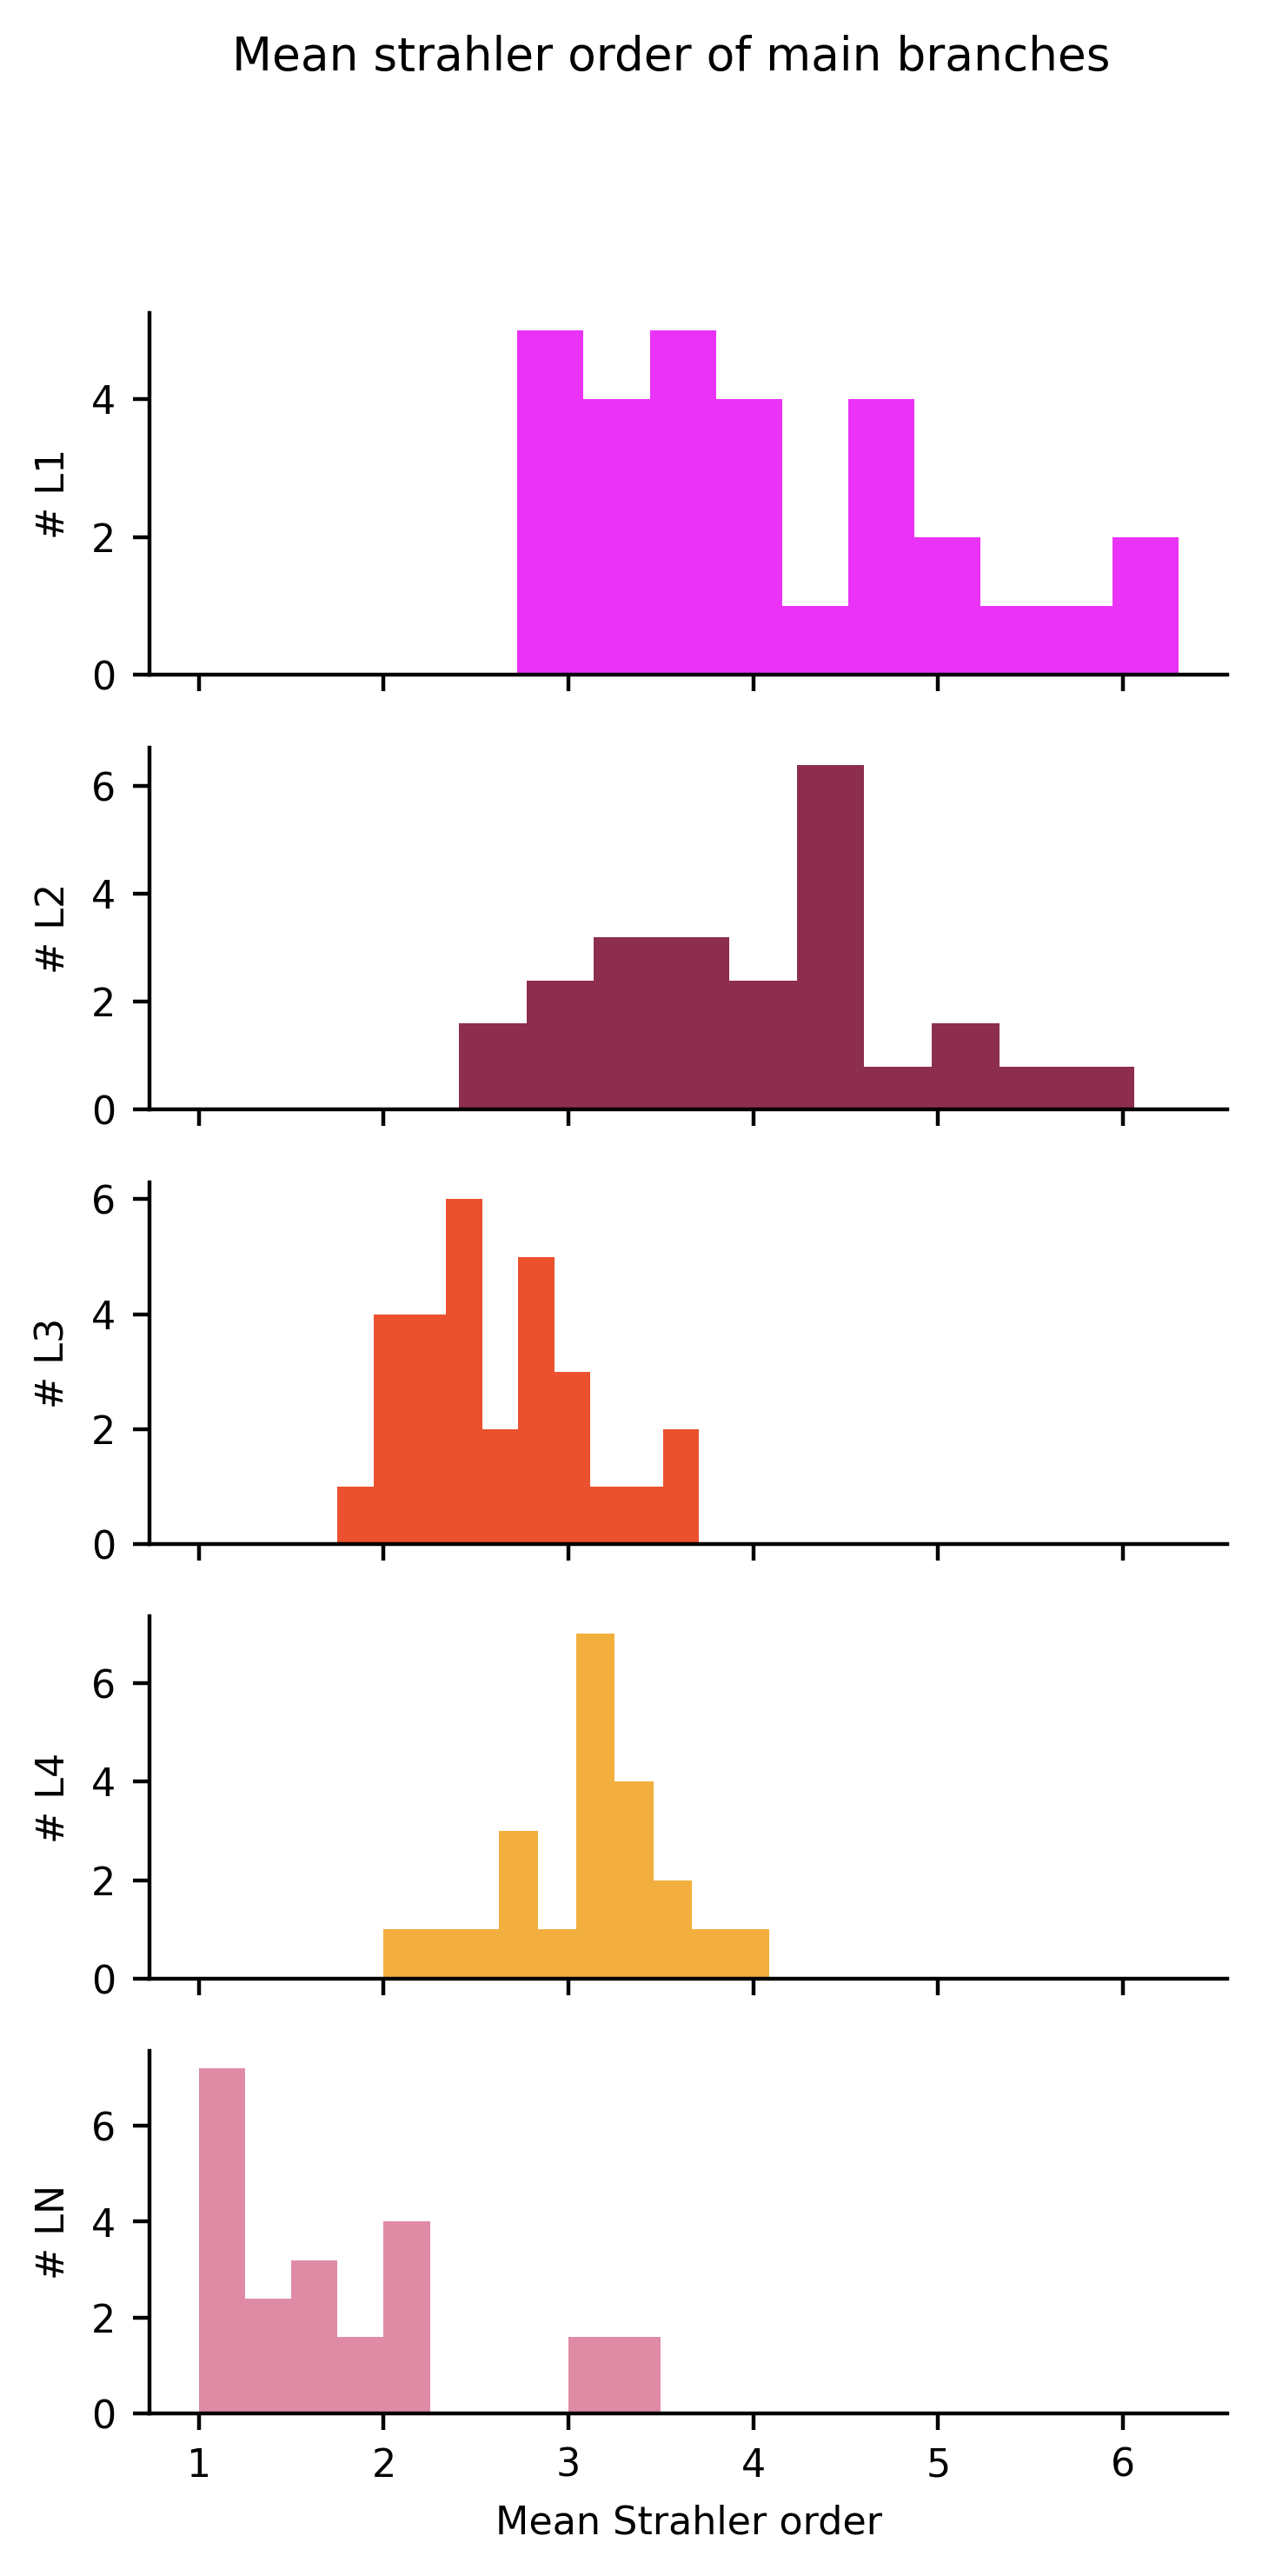

In [10]:
fig, axes = plt.subplots(5, sharex=True, figsize=[4, 8])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
cm = subtype_cm()
for st, neurons in major_branches.groupby('subtype'):
    data = neurons['mean_strahl']
    
    axes[i].hist(data, color=cm[st])
    axes[i].set_ylabel(f"# {st[0] + st[-1]}")
    axes[i].set_yticklabels(np.arange(0, 10, 2))
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
axes[-1].set_xlabel('Mean Strahler order')
fig.suptitle('Mean strahler order of main branches')



In [11]:
### Total path length of major branches ###


total_branch_len = []
for skel, data in major_branches.iterrows():
    skel_id = data['skel_id']
    x = sum([d for i, d in seg_lens[skel_id].items() if i not in central_segs[skel_id]])
    total_branch_len.append(x)

major_branches = major_branches.assign(total_branch_len=total_branch_len)


'Corr between n_major and total_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_inputs   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     153.0
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           6.50e-24
Time:                        18:55:26   Log-Likelihood:                -700.58
No. Observations:                 136   AIC:                             1405.
Df Residuals:                     134   BIC:                             1411.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7512      7.963      1.225      0.223      -5.999      25.501
n_major        5.2071      0.421     12.368      0.000       4.374       6.040
==============================================================================
Omnibus:                        9.749   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.212
Skew:                           0.575   Prob(JB):                      0.00999
Kurtosis:                       2.450   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

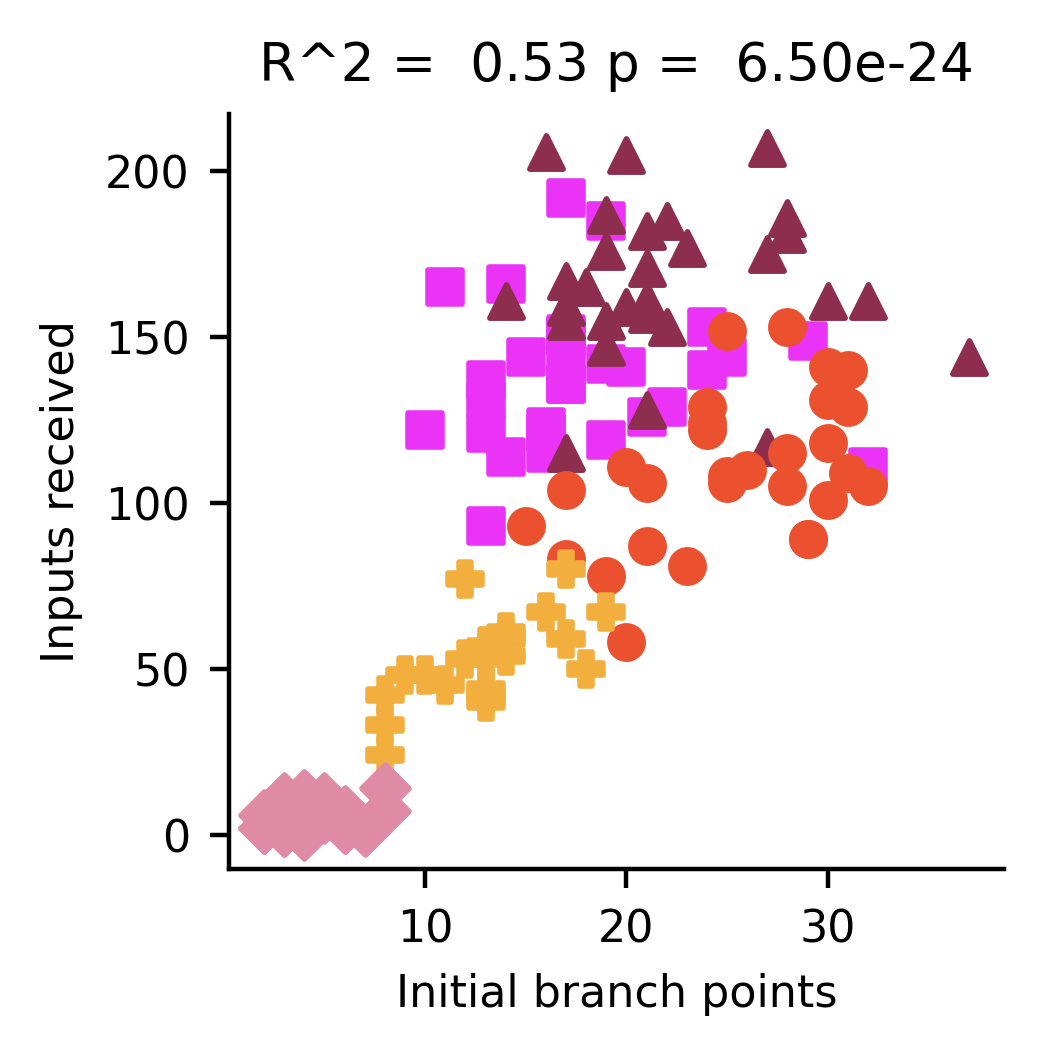

In [44]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'n_major'
y = 'total_inputs'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Initial branch points')
ax.set_ylabel('Inputs received')


if save_figs:
    fig.savefig(fig_path + 'LMC_branch-inputs-scatter.svg')
    fig.savefig(fig_path + 'LMC_branch-inputs-scatter.png')

'Corr between n_major and R1-6_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            R1-6_inputs   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     112.8
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           1.70e-19
Time:                        18:20:24   Log-Likelihood:                -685.97
No. Observations:                 136   AIC:                             1376.
Df Residuals:                     134   BIC:                             1382.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8762      7.152      0.822      0.413      -8.270      20.022
n_major        4.0165      0.378     10.622      0.000       3.269       4.764
==============================================================================
Omnibus:                        9.760   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.687
Skew:                           0.604   Prob(JB):                      0.00788
Kurtosis:                       2.502   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Text(0, 0.5, 'R1-6 inputs received')

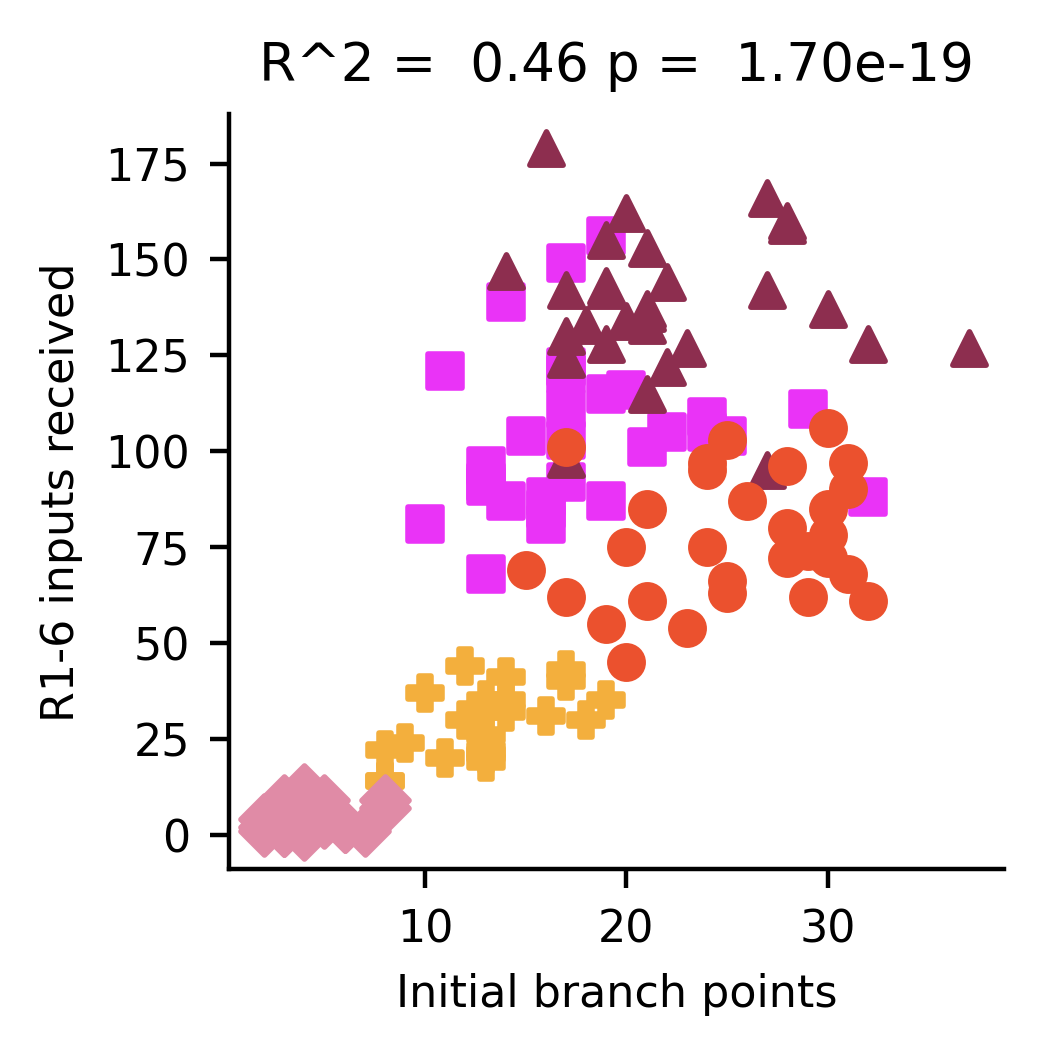

In [14]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'n_major'
y = 'R1-6_inputs'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Initial branch points')
ax.set_ylabel('R1-6 inputs received')


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               R25_bias   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.218
Method:                 Least Squares   F-statistic:                     24.96
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           3.09e-06
Time:                        18:56:15   Log-Likelihood:                -13.931
No. Observations:                  87   AIC:                             31.86
Df Residuals:                      85   BIC:                             36.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.2658      0.110     11.510      0.000       1.047       1.484
mean_strahl    -0.1479      0.030     -4.996      0.000      -0.207      -0.089
==============================================================================
Omnibus:                       26.621   Durbin-Watson:                   2.037
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               47.898
Skew:                           1.192   Prob(JB):                     3.97e-11
Kurtosis:                       5.744   Cond. No.                         14.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

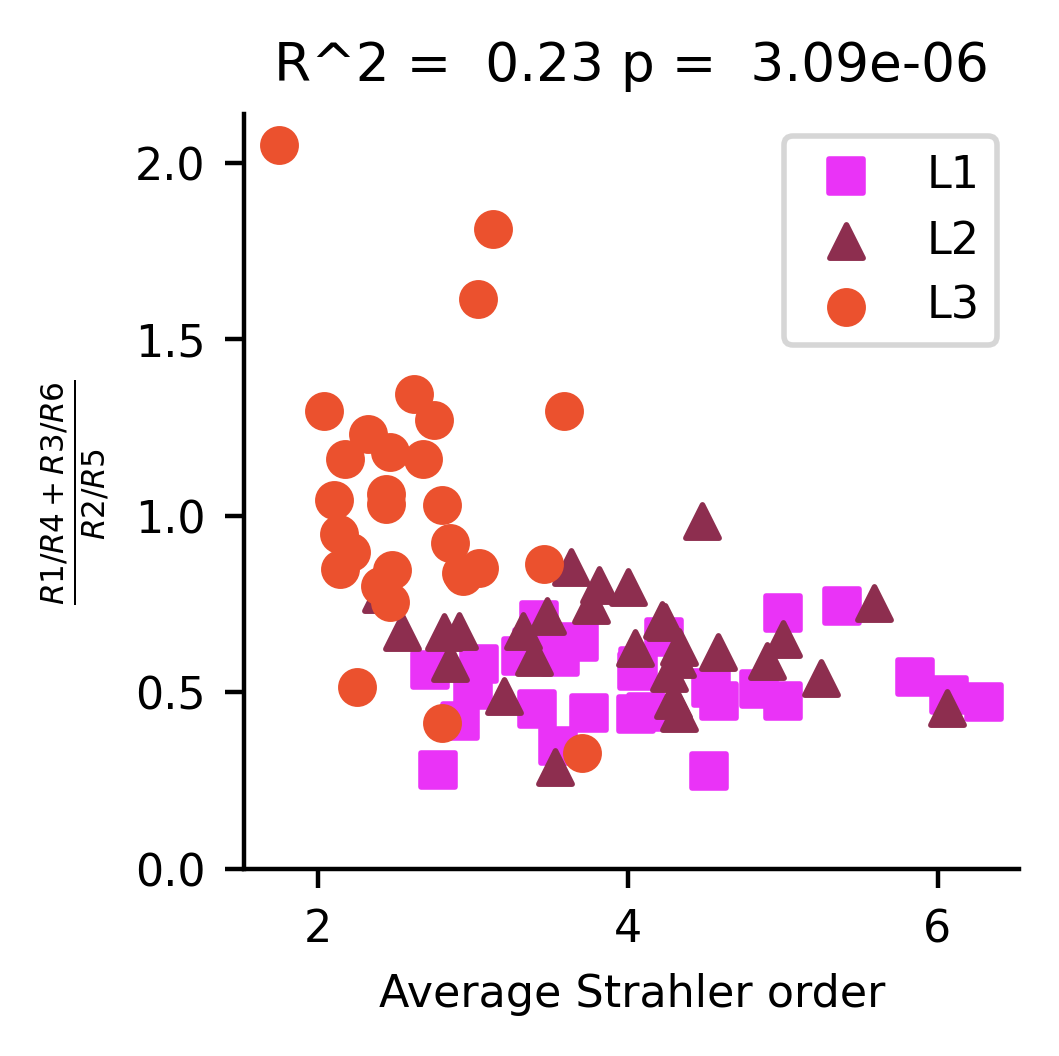

In [45]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

incl_lmcs = ['LMC_1', 'LMC_2', 'LMC_3']
data = major_branches.loc[[i for i, row in major_branches.iterrows() if row.subtype in incl_lmcs], :]
x = data['mean_strahl']
y = data['R25_bias']

X = sm.add_constant(x)
Y = y

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):

    x_vars = rows['mean_strahl']
    y_vars = rows['R25_bias']
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Average Strahler order')
ax.set_ylabel(r'$\frac{Quartet inputs}{Duet inputs}$')
plt.yticks(np.arange(0.0, y.max(), 0.5))
ax.legend()


if save_figs:
    fig.savefig(fig_path + 'L1-3_strahler_r2r5-bias.svg')
    fig.savefig(fig_path + 'L1-3_strahler_r2r5-bias.png')

'Corr between n_major and mean_strahl'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            mean_strahl   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     5.977
Date:                Wed, 21 Jul 2021   Prob (F-statistic):             0.0158
Time:                        17:35:26   Log-Likelihood:                -210.86
No. Observations:                 136   AIC:                             425.7
Df Residuals:                     134   BIC:                             431.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.6493      0.217     12.187      0.000       2.219       3.079
n_major        0.0281      0.011      2.445      0.016       0.005       0.051
==============================================================================
Omnibus:                        7.606   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.022   Jarque-Bera (JB):                7.754
Skew:                           0.585   Prob(JB):                       0.0207
Kurtosis:                       3.008   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

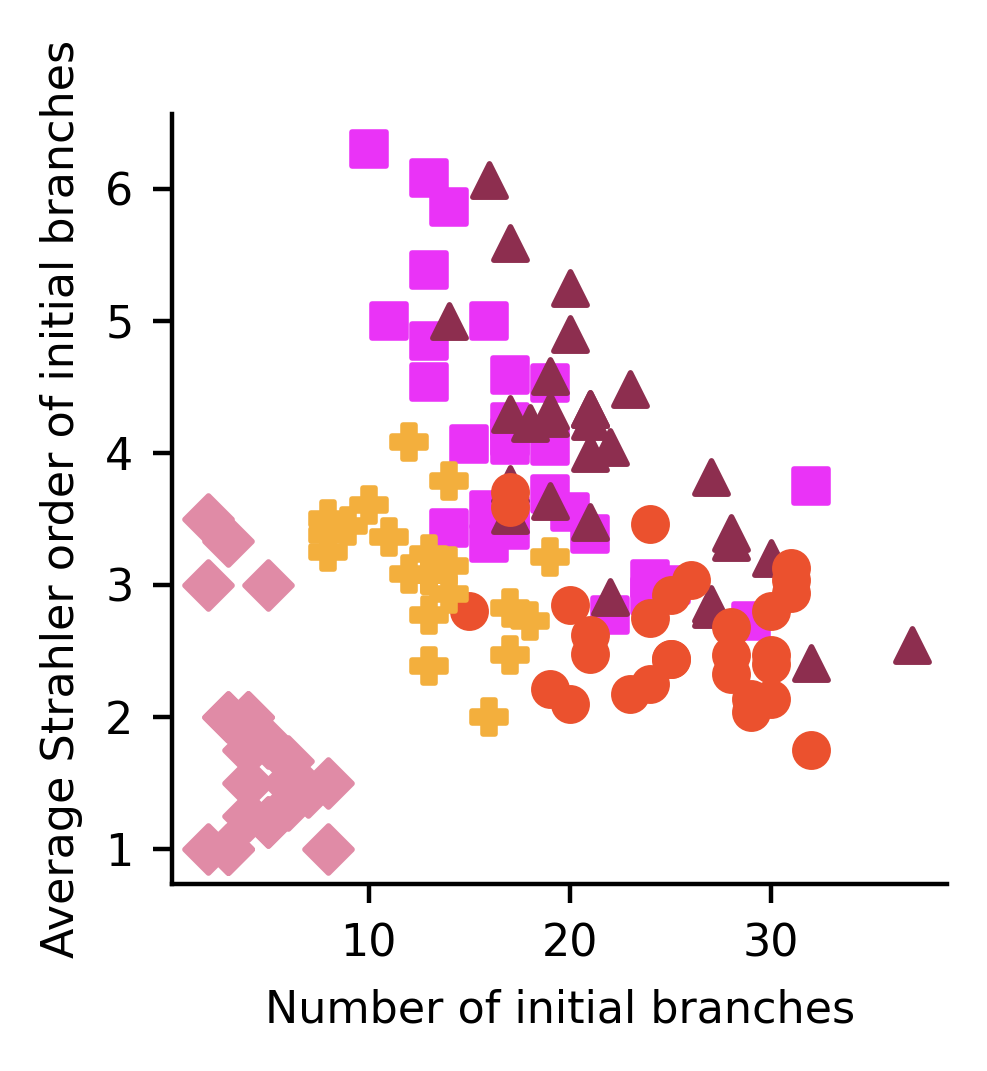

In [18]:
fig, ax = plt.subplots(1, figsize=[2.5, 2.5])

data = major_branches
x = 'n_major'
y = 'mean_strahl'

display(f"Corr between {x} and {y}")
X = data[x]
X = sm.add_constant(X)
Y = data[y]

model = sm.OLS(Y, X)
results = model.fit()
display(results.summary())

#ax = sns.regplot(x=x, y=y, data=data, scatter=False, color='k', ci=95)
for st, rows in data.groupby('subtype'):
    x_vars = rows[x]
    y_vars = rows[y]
    ax.scatter(x_vars, y_vars, marker=m[st], c=cm[st], label=f"{st[0] + st.split('_')[1]}")

#ax.set_title(f'R^2 = {results.rsquared: .02f} p = {results.f_pvalue: .2e}')
ax.set_xlabel('Number of initial branches')
ax.set_ylabel('Average Strahler order of initial branches')


fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-initial_2Dscatter.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_strahl-v-initial_2Dscatter.png')


/tmp/ipykernel_1867553/3672364266.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


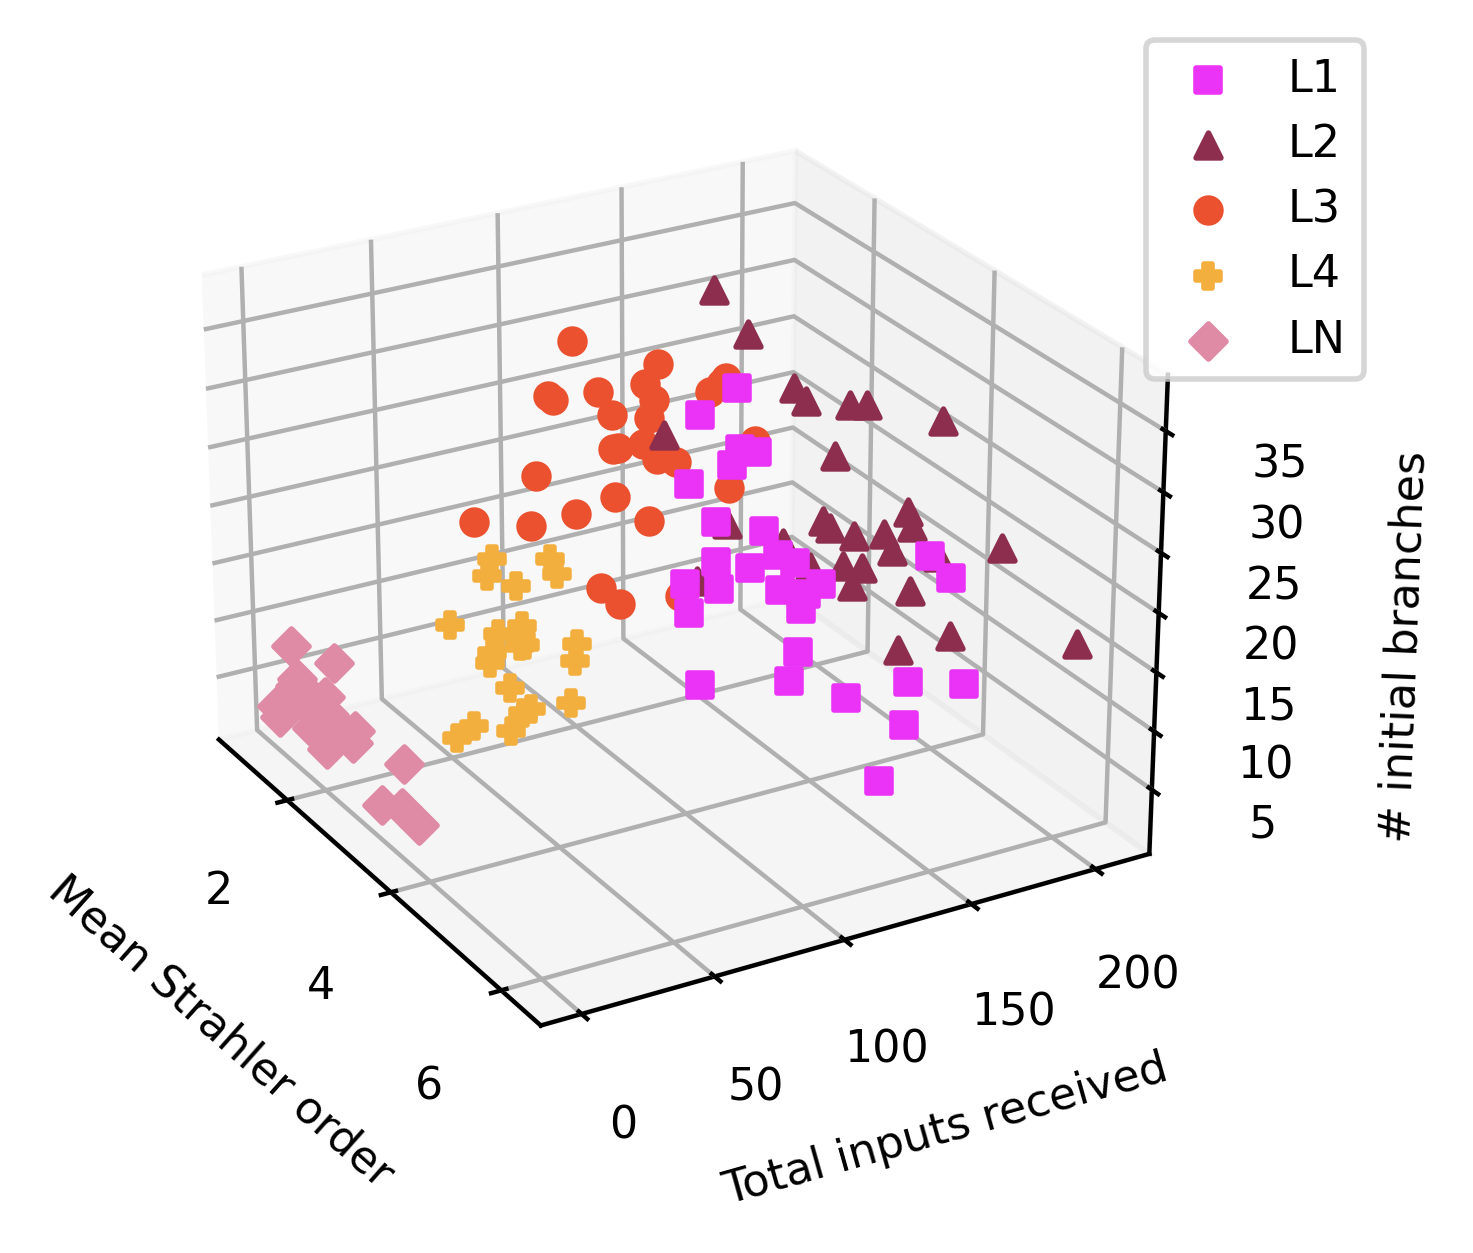

In [19]:
fig = plt.figure(figsize=[3.5, 3.5])
ax = fig.gca(projection='3d')
ax.set_xlabel('Mean Strahler order')
ax.set_ylabel('Total inputs received')
ax.set_zlabel('# initial branches')


c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in major_branches.groupby('subtype'):
    
    x = rows['mean_strahl']
    y = rows['total_inputs']
    z = rows['n_major']
    
    
    ax.scatter(x, y, z, 
               label=f"L{pre.split('_')[1]}", 
               marker=m[pre],
               c=c[pre], 
               alpha=1.0, 
               depthshade=False)
    
    #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_zaxis()
ax.view_init(elev=25, azim=-30)

plt.show()


fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_morph_3Dscatter_smaller.svg')
fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/3-lmcs/LMC_morph_3Dscatter_smaller.png')

/tmp/ipykernel_1867553/206762426.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


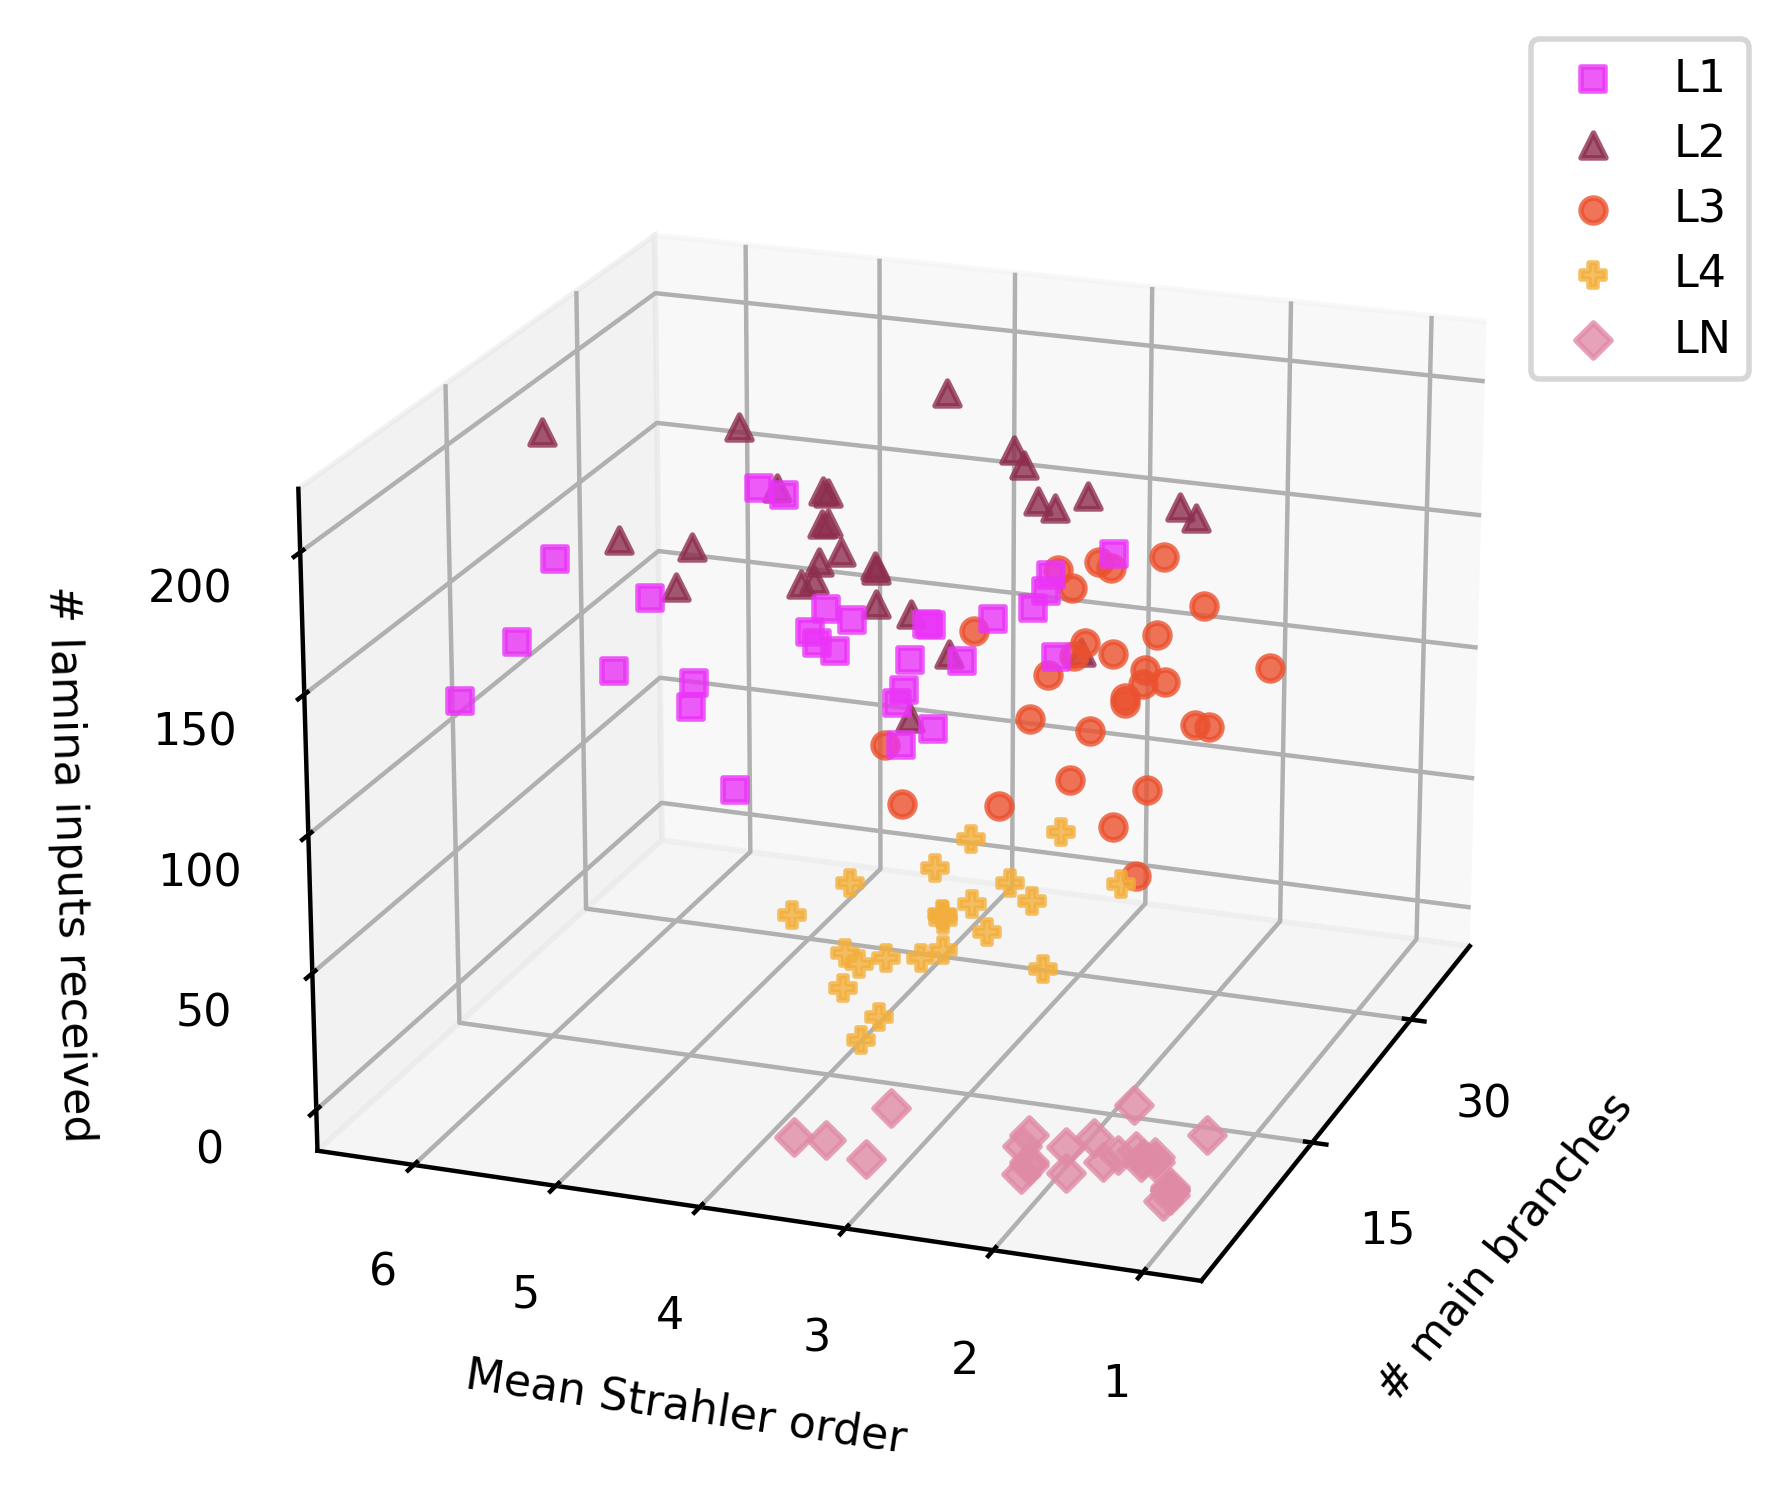

In [20]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_ylabel('Mean Strahler order')
ax.set_zlabel('# lamina inputs received')
ax.set_xlabel('# main branches')


c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in major_branches.groupby('subtype'):
    
    y = rows['mean_strahl']
    z = rows['total_inputs']
    x = rows['n_major']
    
    
    ax.scatter(x, y, z, 
               label=f"L{pre.split('_')[1]}", 
               marker=m[pre],
               c=c[pre], 
               alpha=0.8, 
               depthshade=False)
    
    #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_zaxis()
ax.view_init(elev=20, azim=200)

plt.show()

# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.png')

/tmp/ipykernel_1867553/1287512324.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


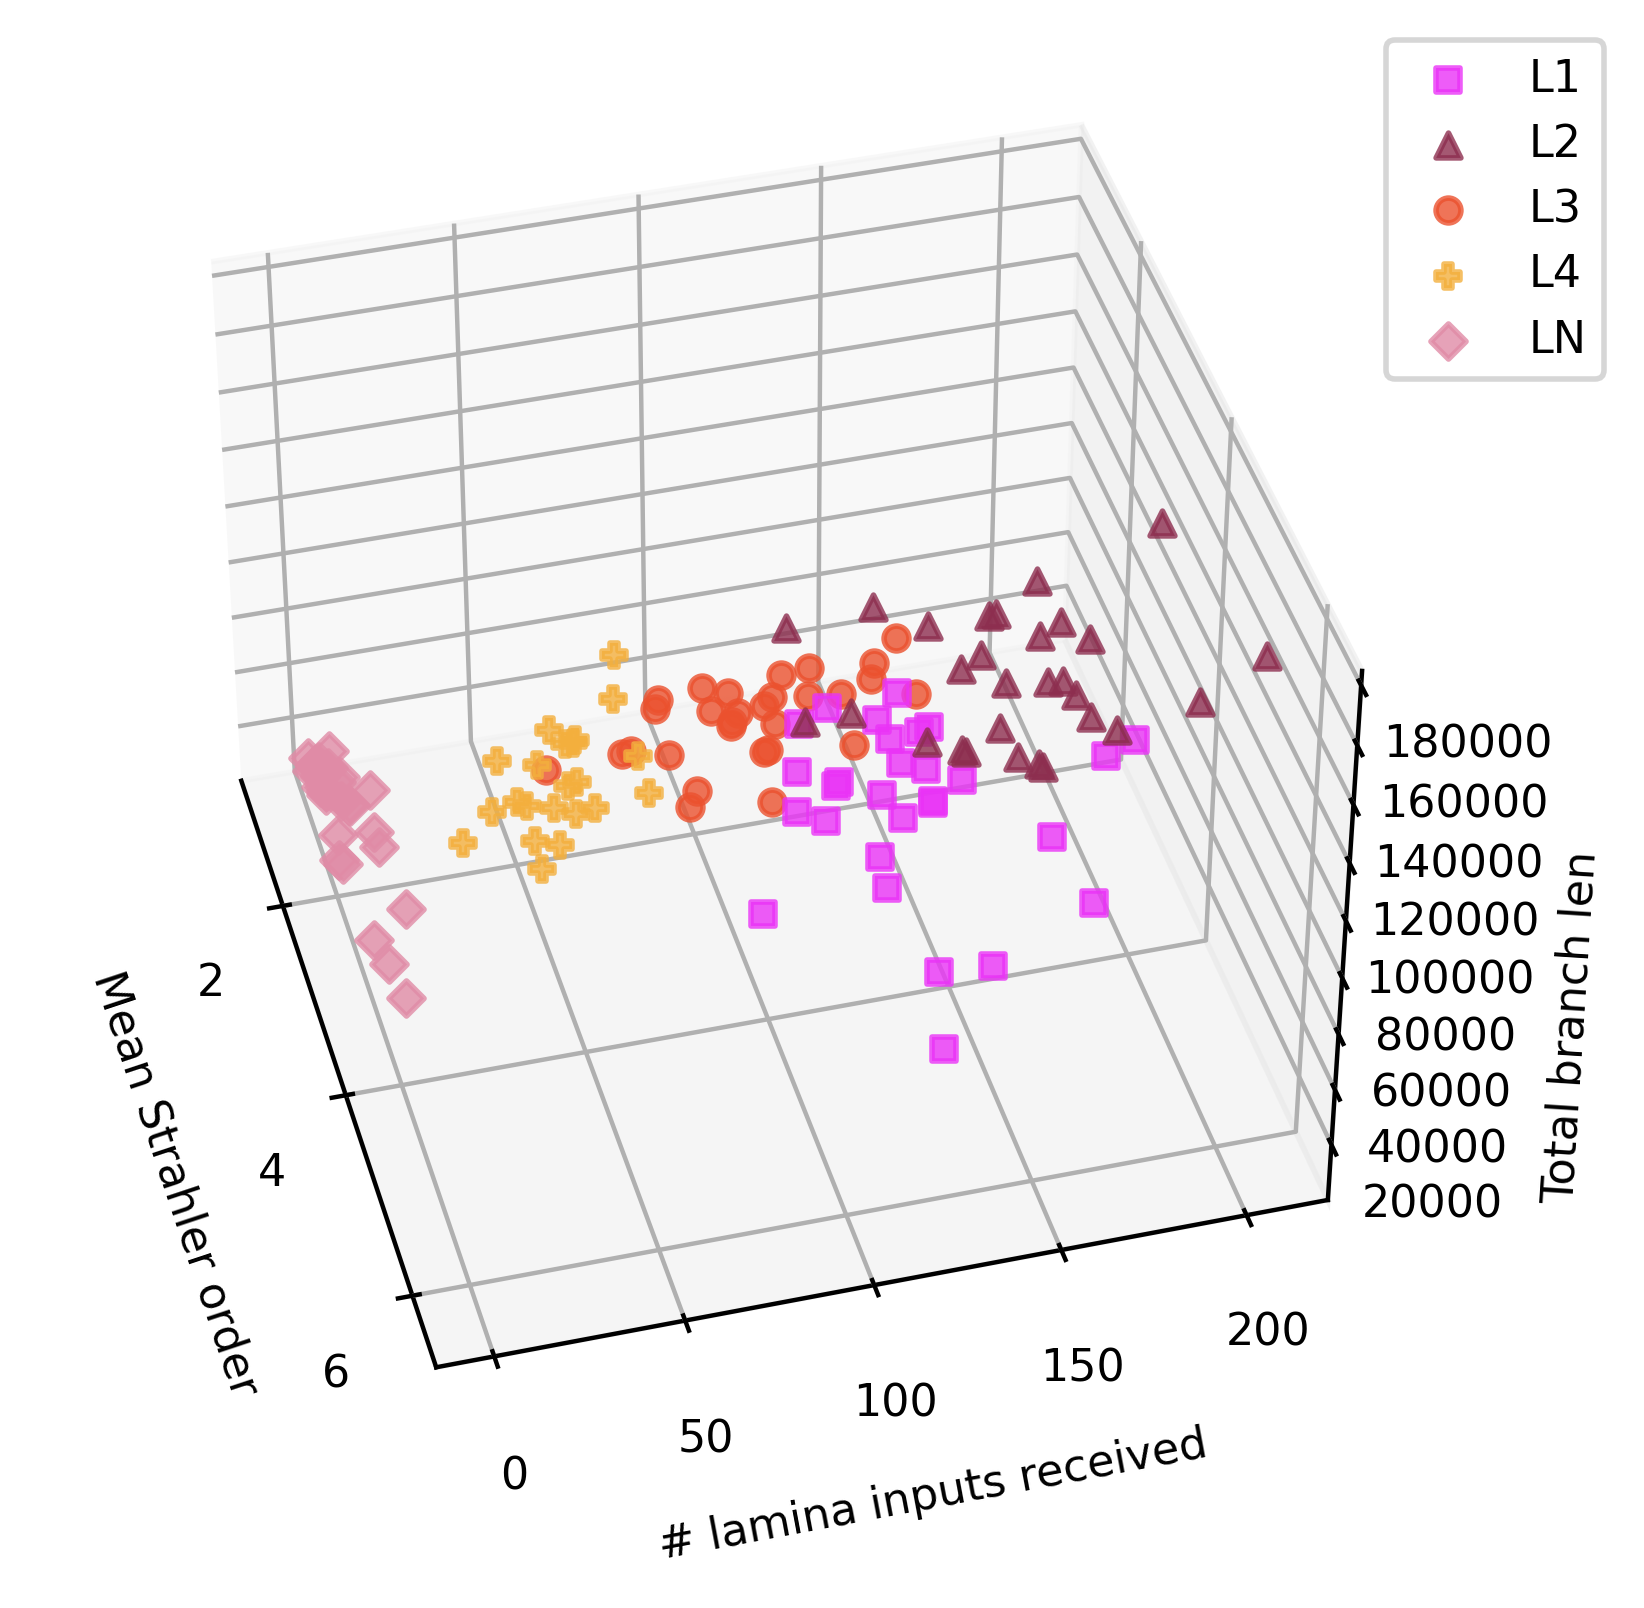

In [21]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_xlabel('Mean Strahler order')
ax.set_ylabel('# lamina inputs received')
ax.set_zlabel('Total branch len')

c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in major_branches.groupby('subtype'):
    
    x = rows['mean_strahl']
    y = rows['total_inputs']
    z = rows['total_branch_len']
    
    
    ax.scatter(x, y, z, 
               label=f"L{pre.split('_')[1]}", 
               marker=m[pre],
               c=c[pre], 
               alpha=0.8, 
               depthshade=False)
    
    #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_yaxis()
ax.view_init(elev=40, azim=-15)

plt.show()

# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.png')

/tmp/ipykernel_1867553/677559967.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


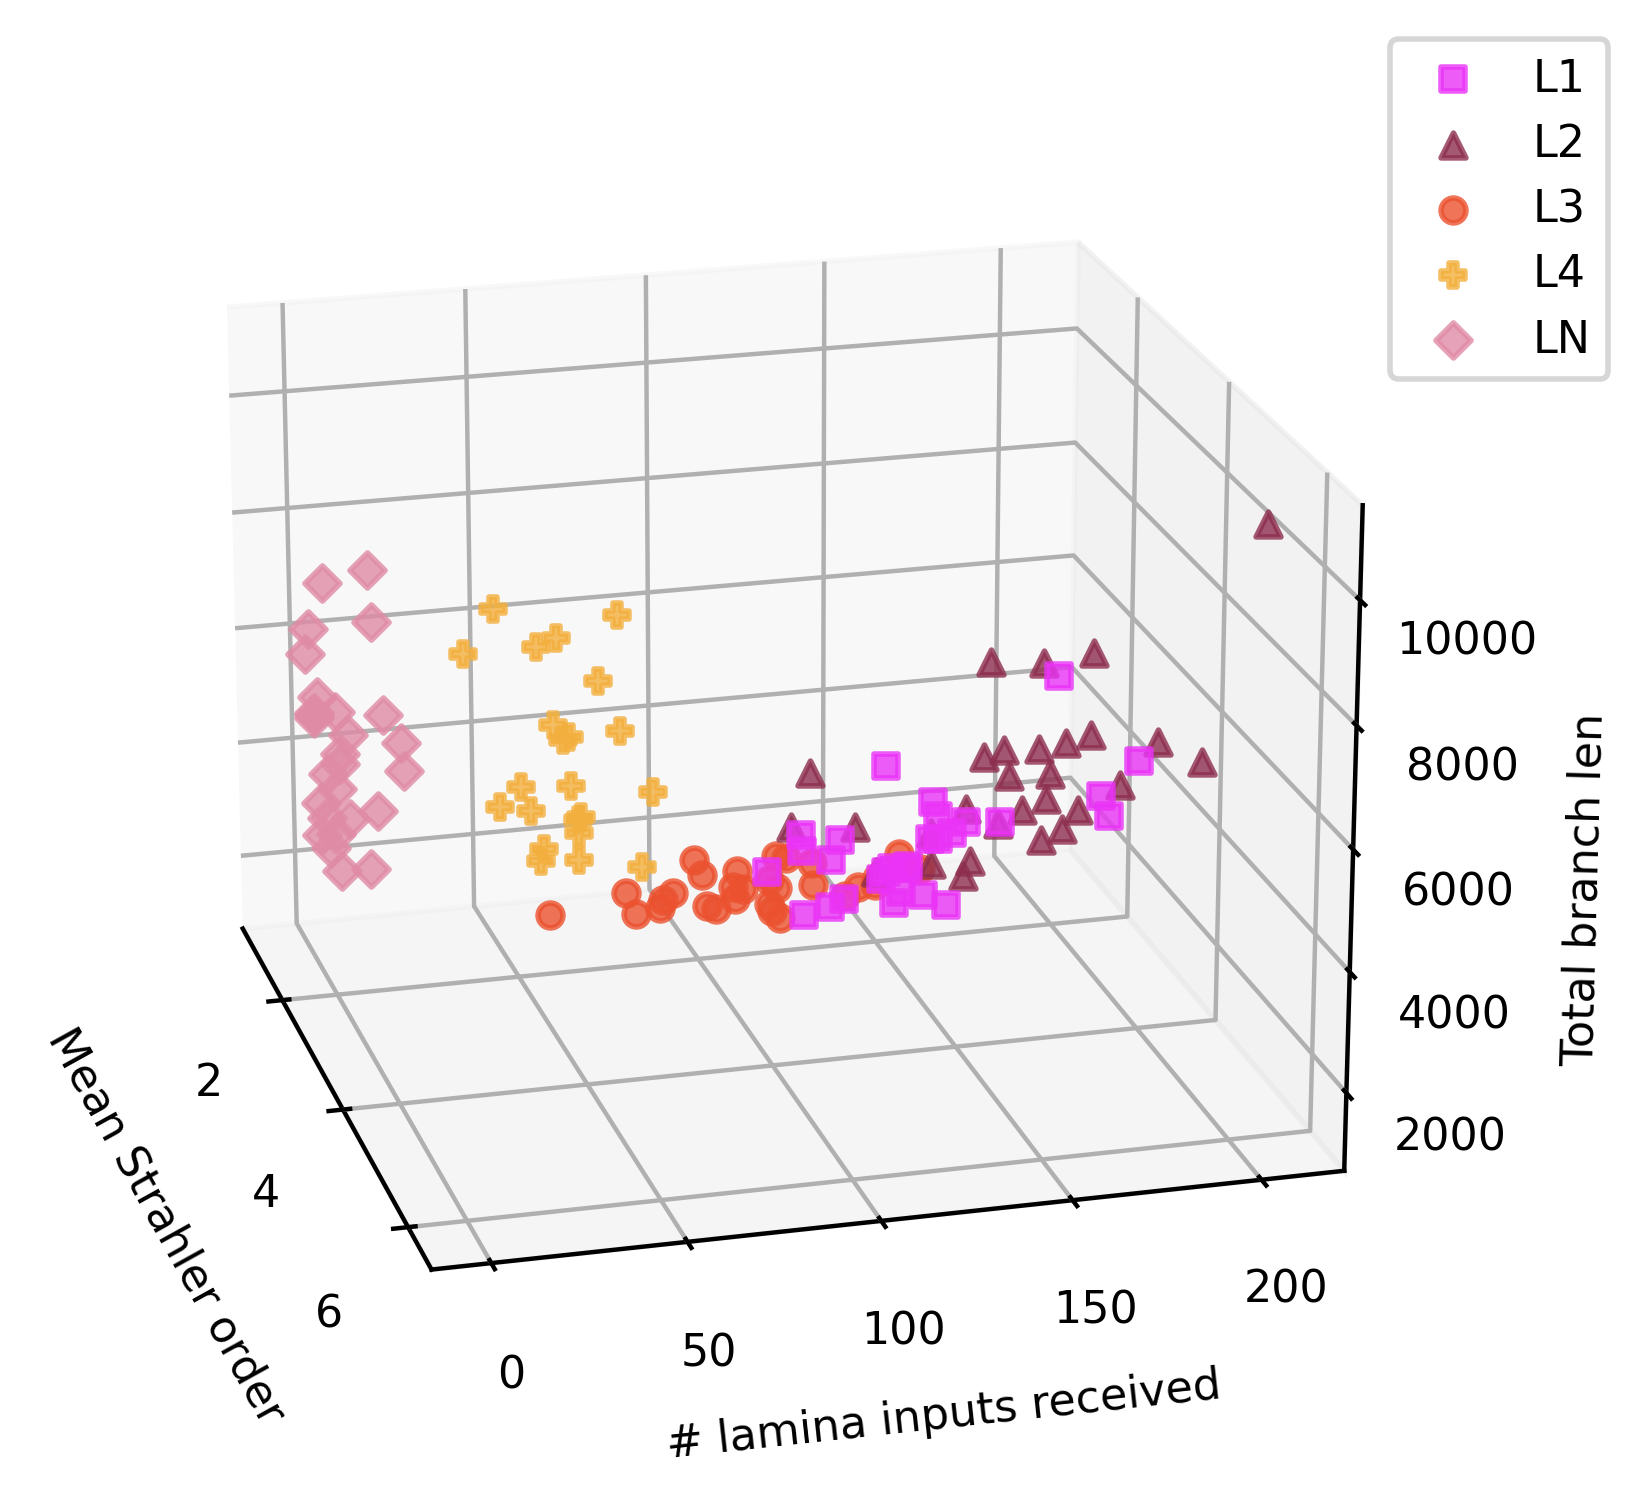

In [22]:
fig = plt.figure(figsize=[4.6, 4.6])
ax = fig.gca(projection='3d')
ax.set_xlabel('Mean Strahler order')
ax.set_ylabel('# lamina inputs received')
ax.set_zlabel('Total branch len')

c = subtype_cm()

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

for pre, rows in major_branches.groupby('subtype'):
    
    x = rows['mean_strahl']
    y = rows['total_inputs']
    z = rows['total_branch_len']/rows['n_major']
    
    
    ax.scatter(x, y, z, 
               label=f"L{pre.split('_')[1]}", 
               marker=m[pre],
               c=c[pre], 
               alpha=0.8, 
               depthshade=False)
    
    #ax.scatter(rows['R1R4'] + rows['R3R6'], rows['inter_in'], rows['output_count'], label=pre)
plt.legend(bbox_to_anchor=(0.95, 1), loc='upper left', borderaxespad=0.)
ax.xaxis.set_major_locator(plt.MaxNLocator(3))
#ax.invert_yaxis()
ax.view_init(elev=20, azim=-15)

plt.show()

# if save_figs:
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.svg')
#     fig.savefig('/mnt/home/nchua/Dropbox/lamina_figures/LMC_properties_scatter.png')

Text(0.5, 0, 'Total branch length (microns)')

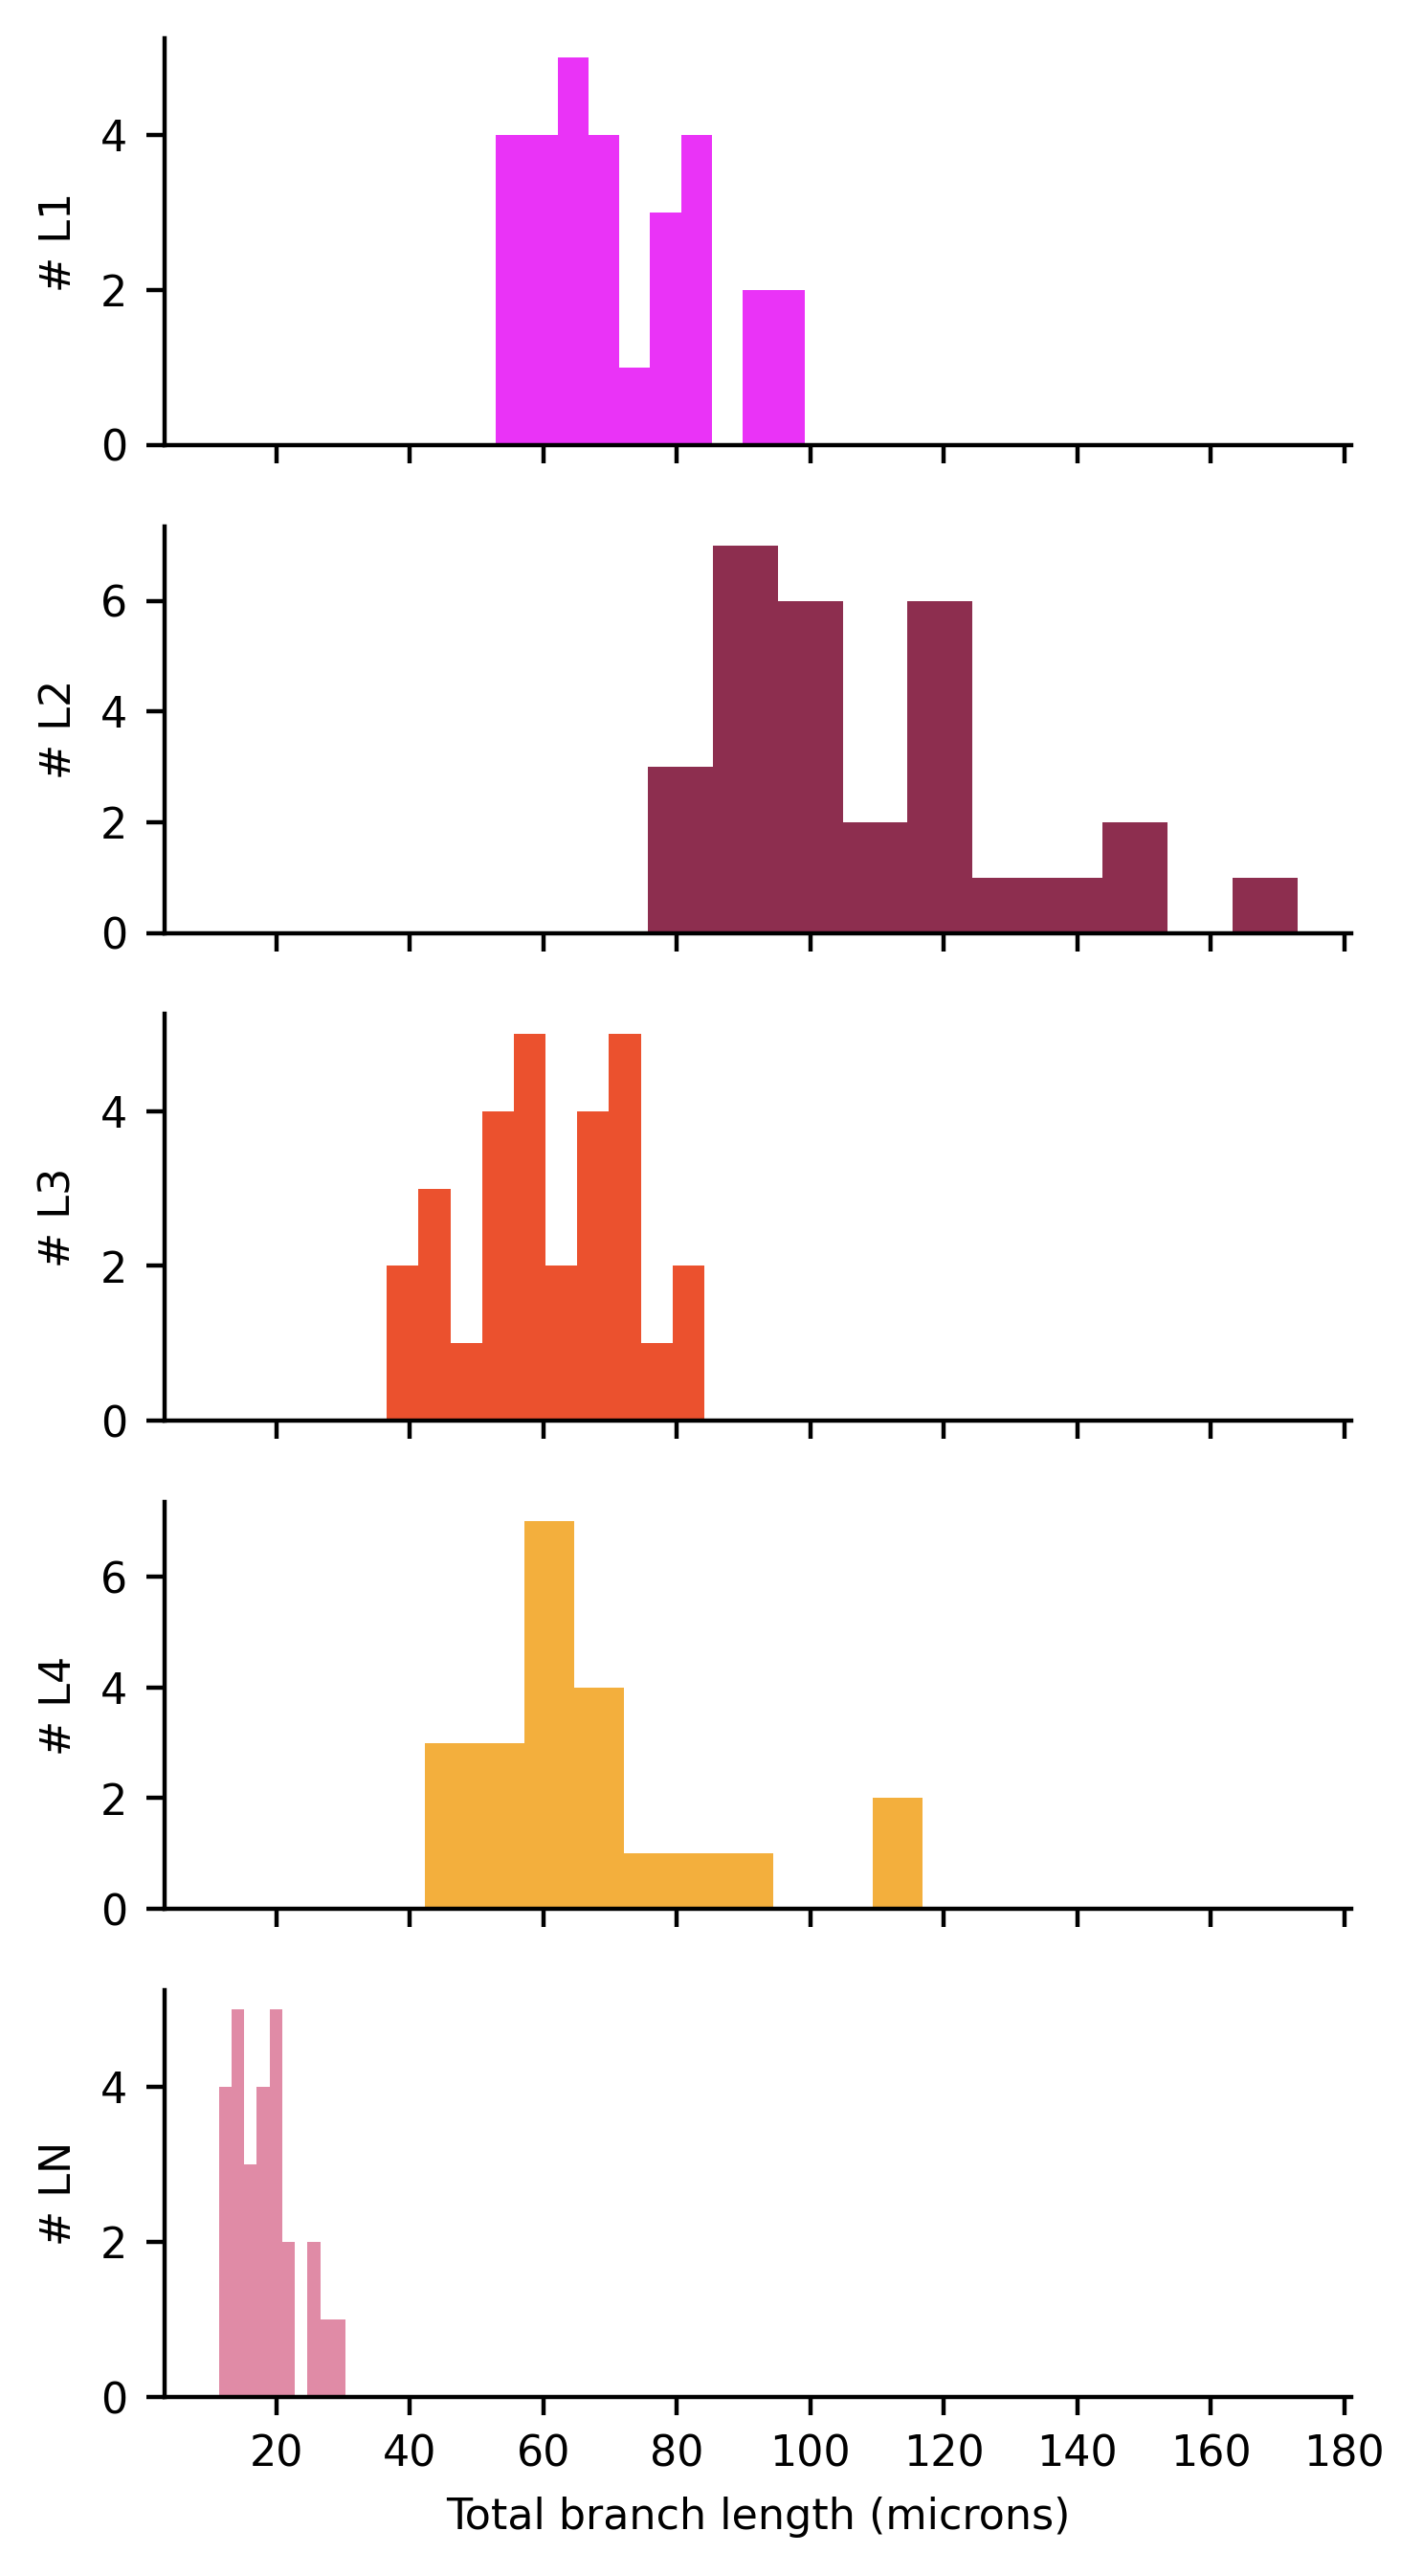

In [23]:
fig, axes = plt.subplots(5, sharex=True, figsize=[4, 8])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
cm = subtype_cm()
for st, neurons in major_branches.groupby('subtype'):
    data = neurons['total_branch_len']
    
    axes[i].hist(data/1000.0, color=cm[st])
    axes[i].set_ylabel(f"# {st[0] + st[-1]}")
    #axes[i].set_yticklabels(np.arange(0, 10, 2))
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
axes[-1].set_xlabel('Total branch length (microns)')

Text(0.5, 0, 'Average branch length (microns)')

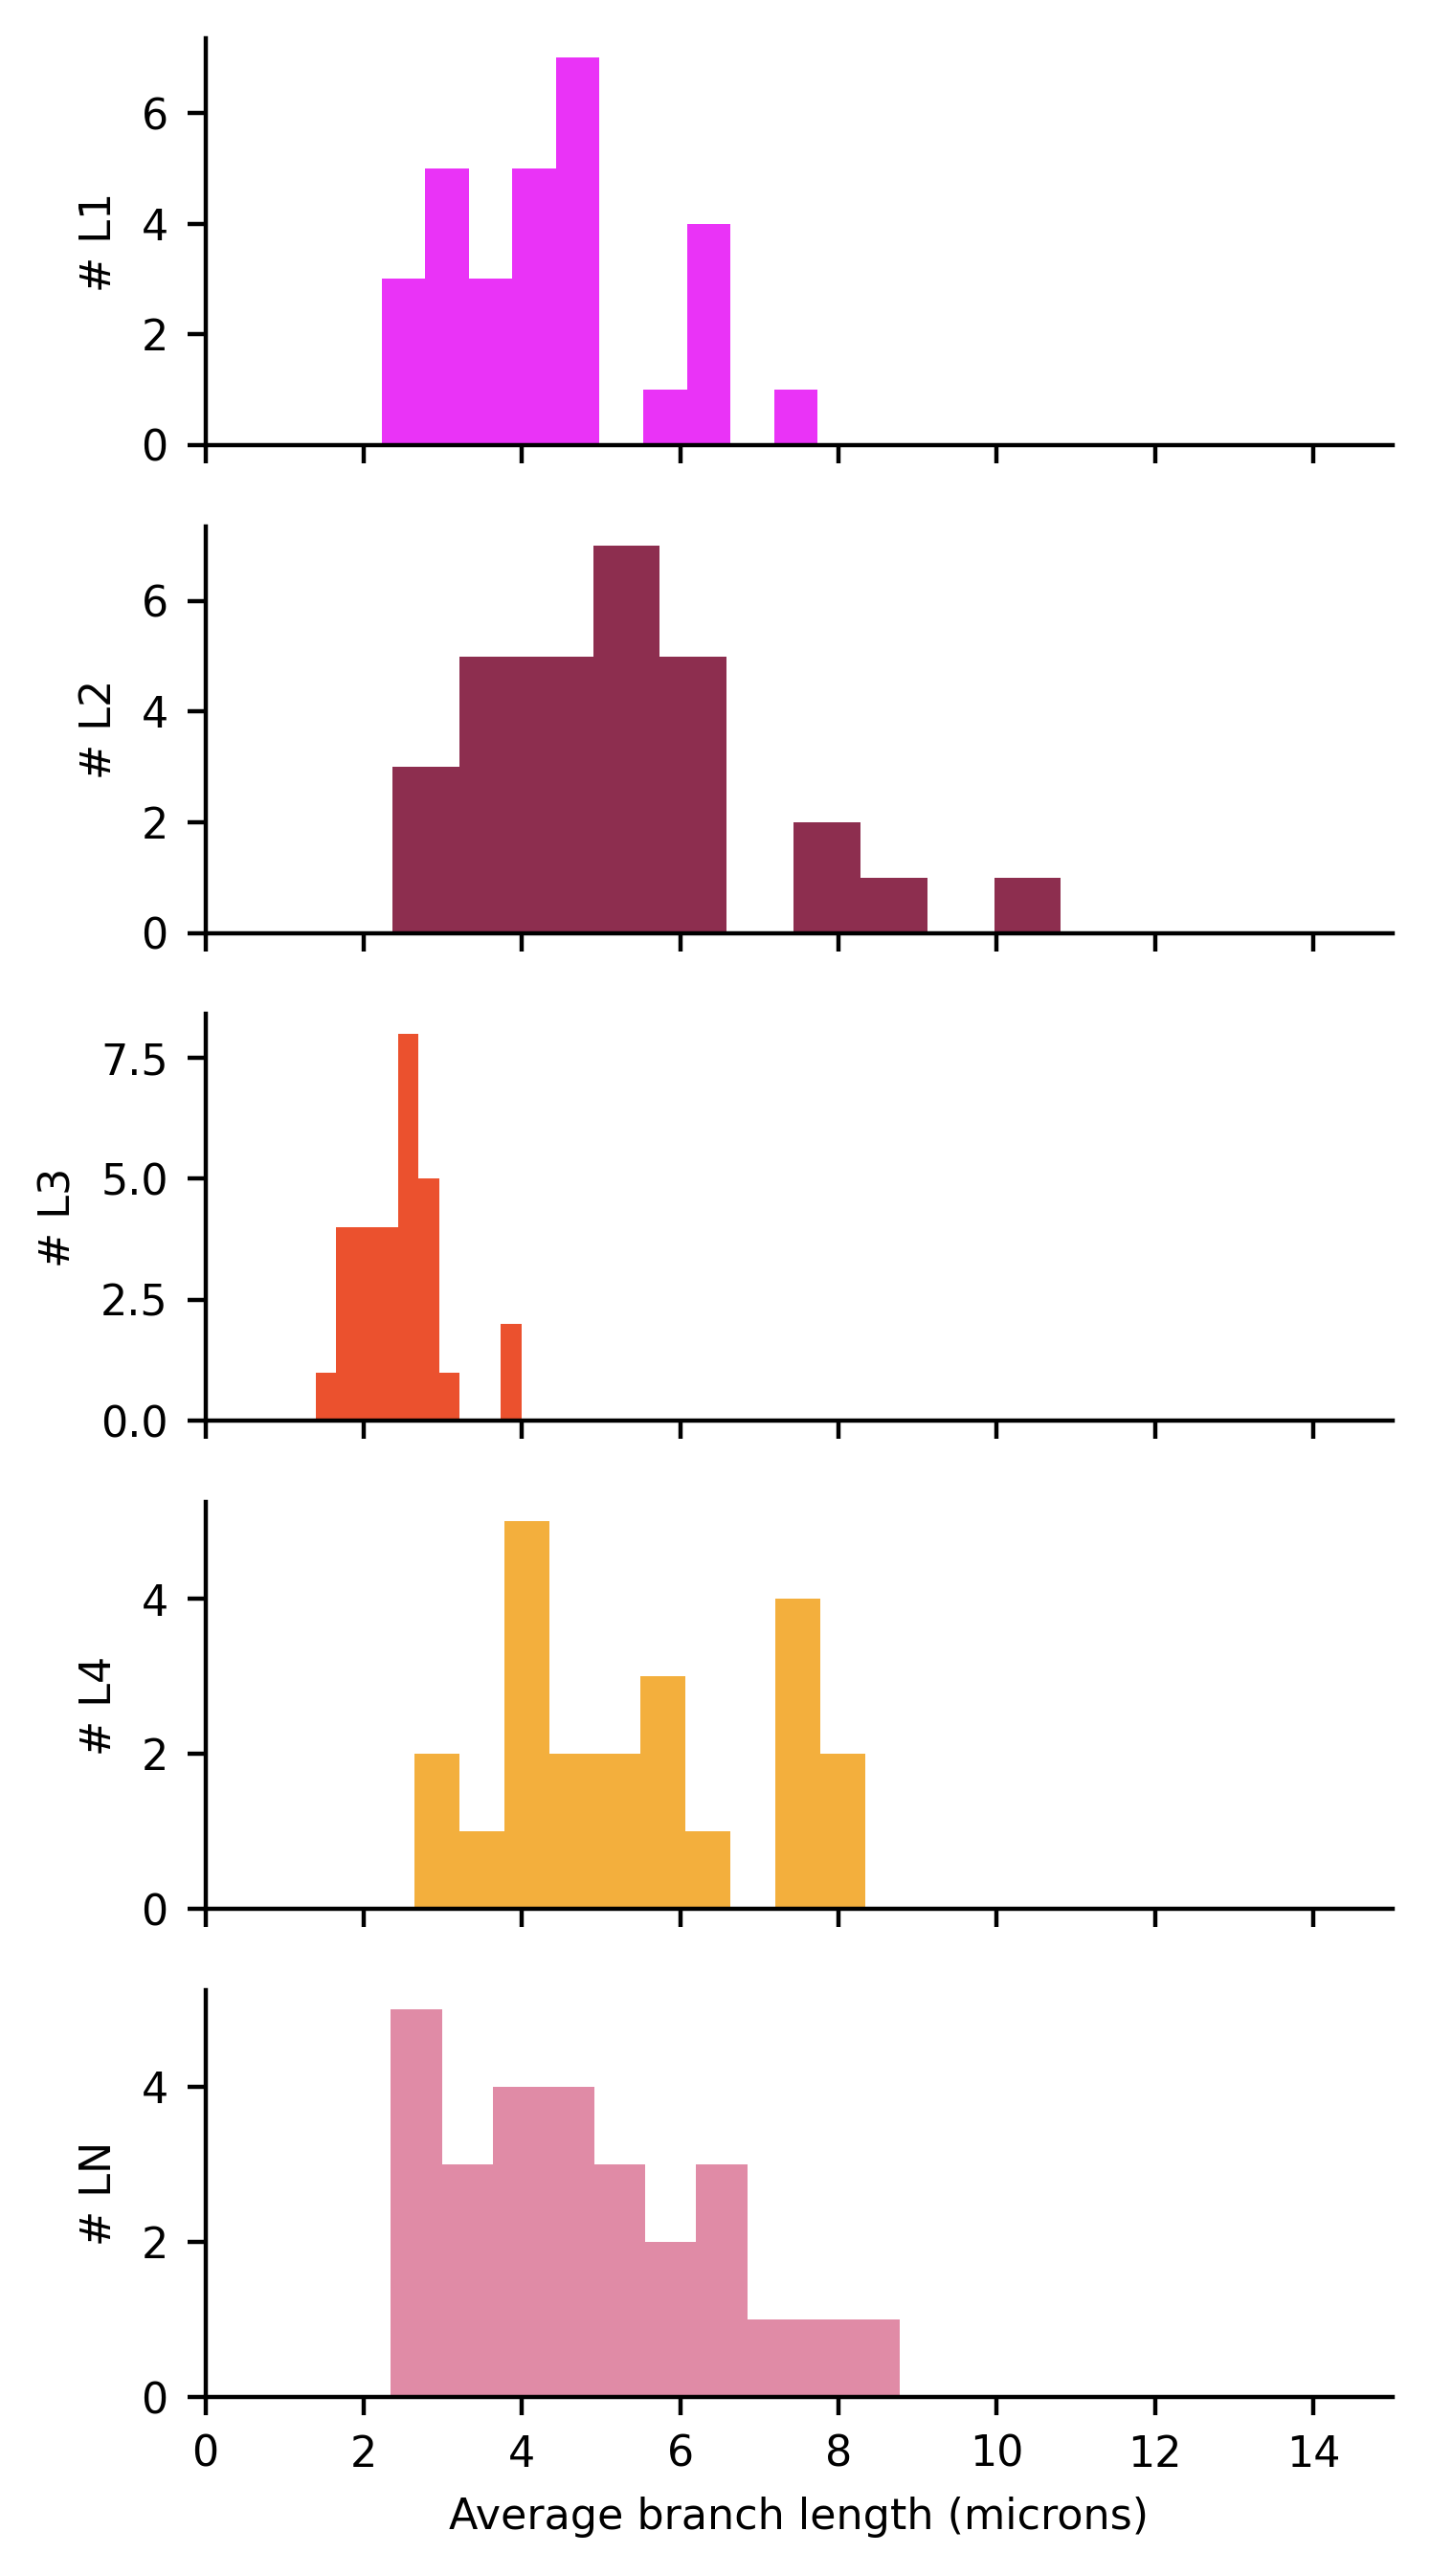

In [24]:
fig, axes = plt.subplots(5, sharex=True, figsize=[4, 8])
#bins = np.arange(1.0, 4.0, 0.05)
i = 0
cm = subtype_cm()
for st, neurons in major_branches.groupby('subtype'):
    data = neurons['total_branch_len']/neurons['n_major']
    
    axes[i].hist(data/1000.0, color=cm[st])
    axes[i].set_ylabel(f"# {st[0] + st[-1]}")
    #axes[i].set_yticklabels(np.arange(0, 10, 2))
    #axes[i,].hist(segs['len'].values)
    #axes[i, 2].hist(segs['strahl_ord'].values)
    i += 1
#     sns.histplot(segs, x='len', ax=axes[i, 1])
#     sns.histplot(segs, x='strahl_ord', ax=axes[i, 2])
axes[-1].set_xlim([0, 15])
axes[-1].set_xlabel('Average branch length (microns)')

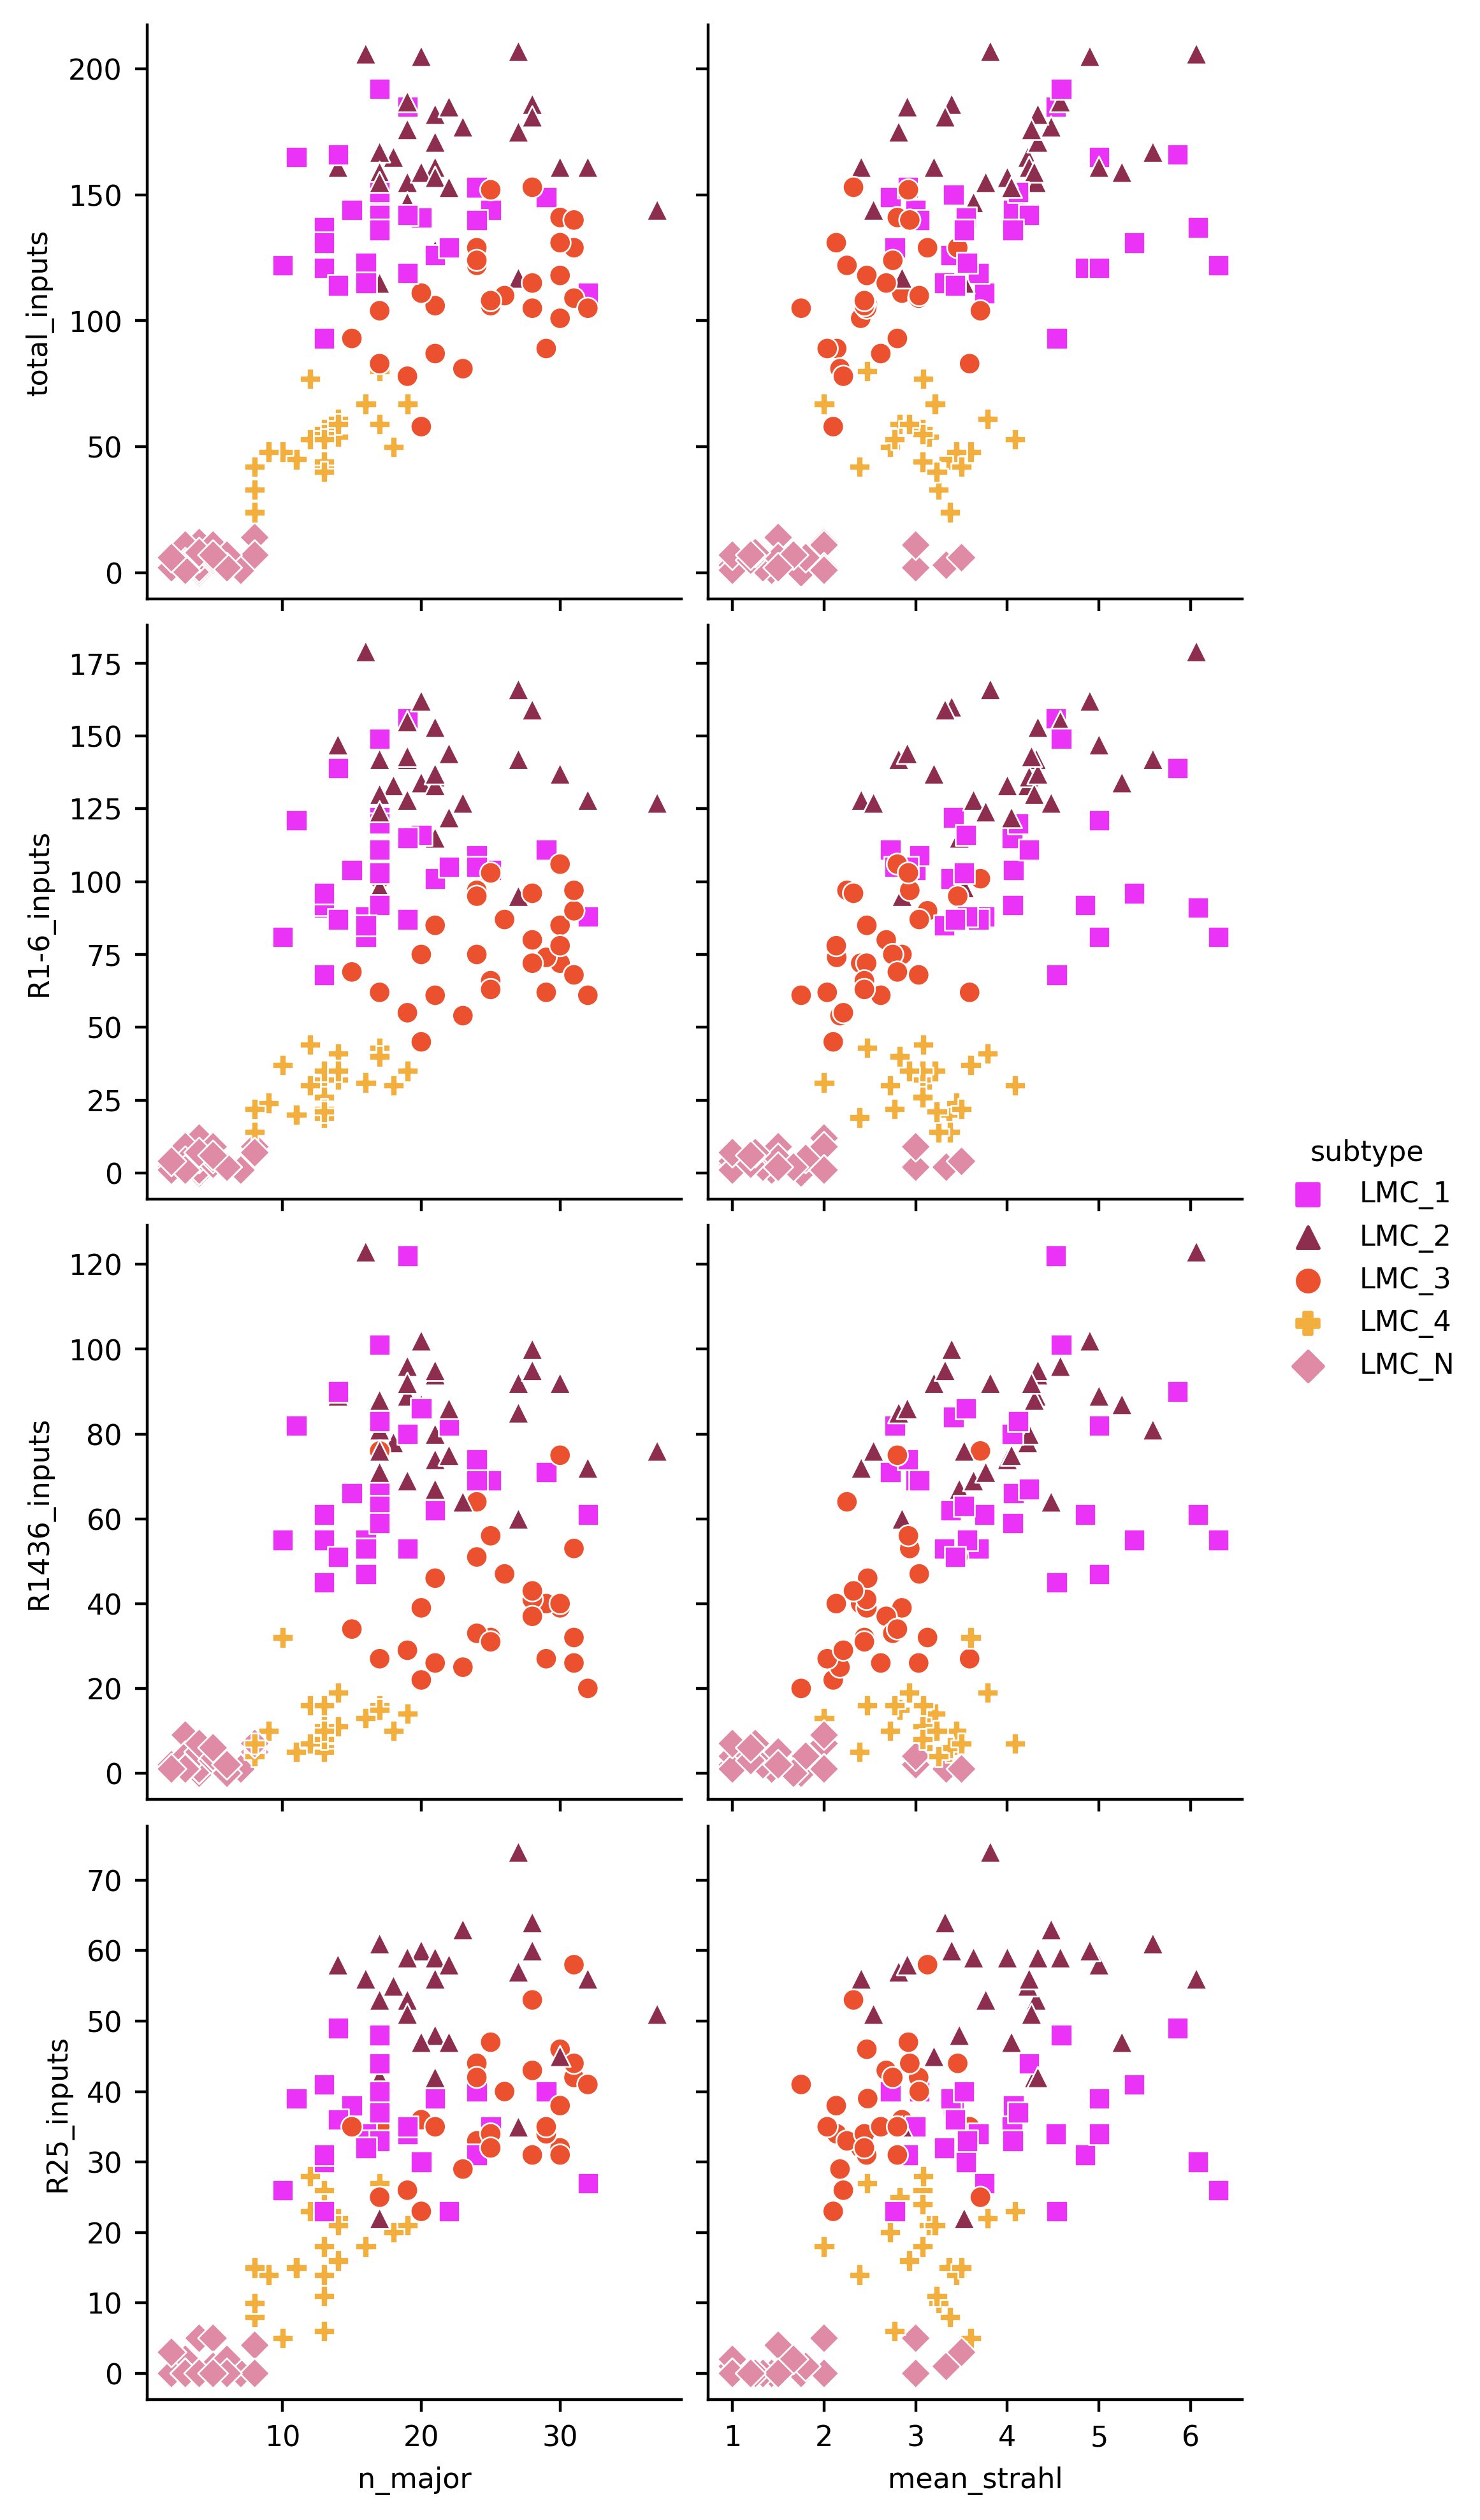

In [25]:
data = major_branches
x_vars=['n_major', 'mean_strahl']
y_vars=['total_inputs', 'R1-6_inputs', 'R1436_inputs', 'R25_inputs']

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

g = sns.pairplot(data, hue='subtype', markers=m, palette=subtype_cm(), 
             x_vars=x_vars, 
             y_vars=y_vars)

g.savefig('/mnt/home/nchua/Dropbox/lamina_figures/210505_LMC_morp_vs_cx.svg')


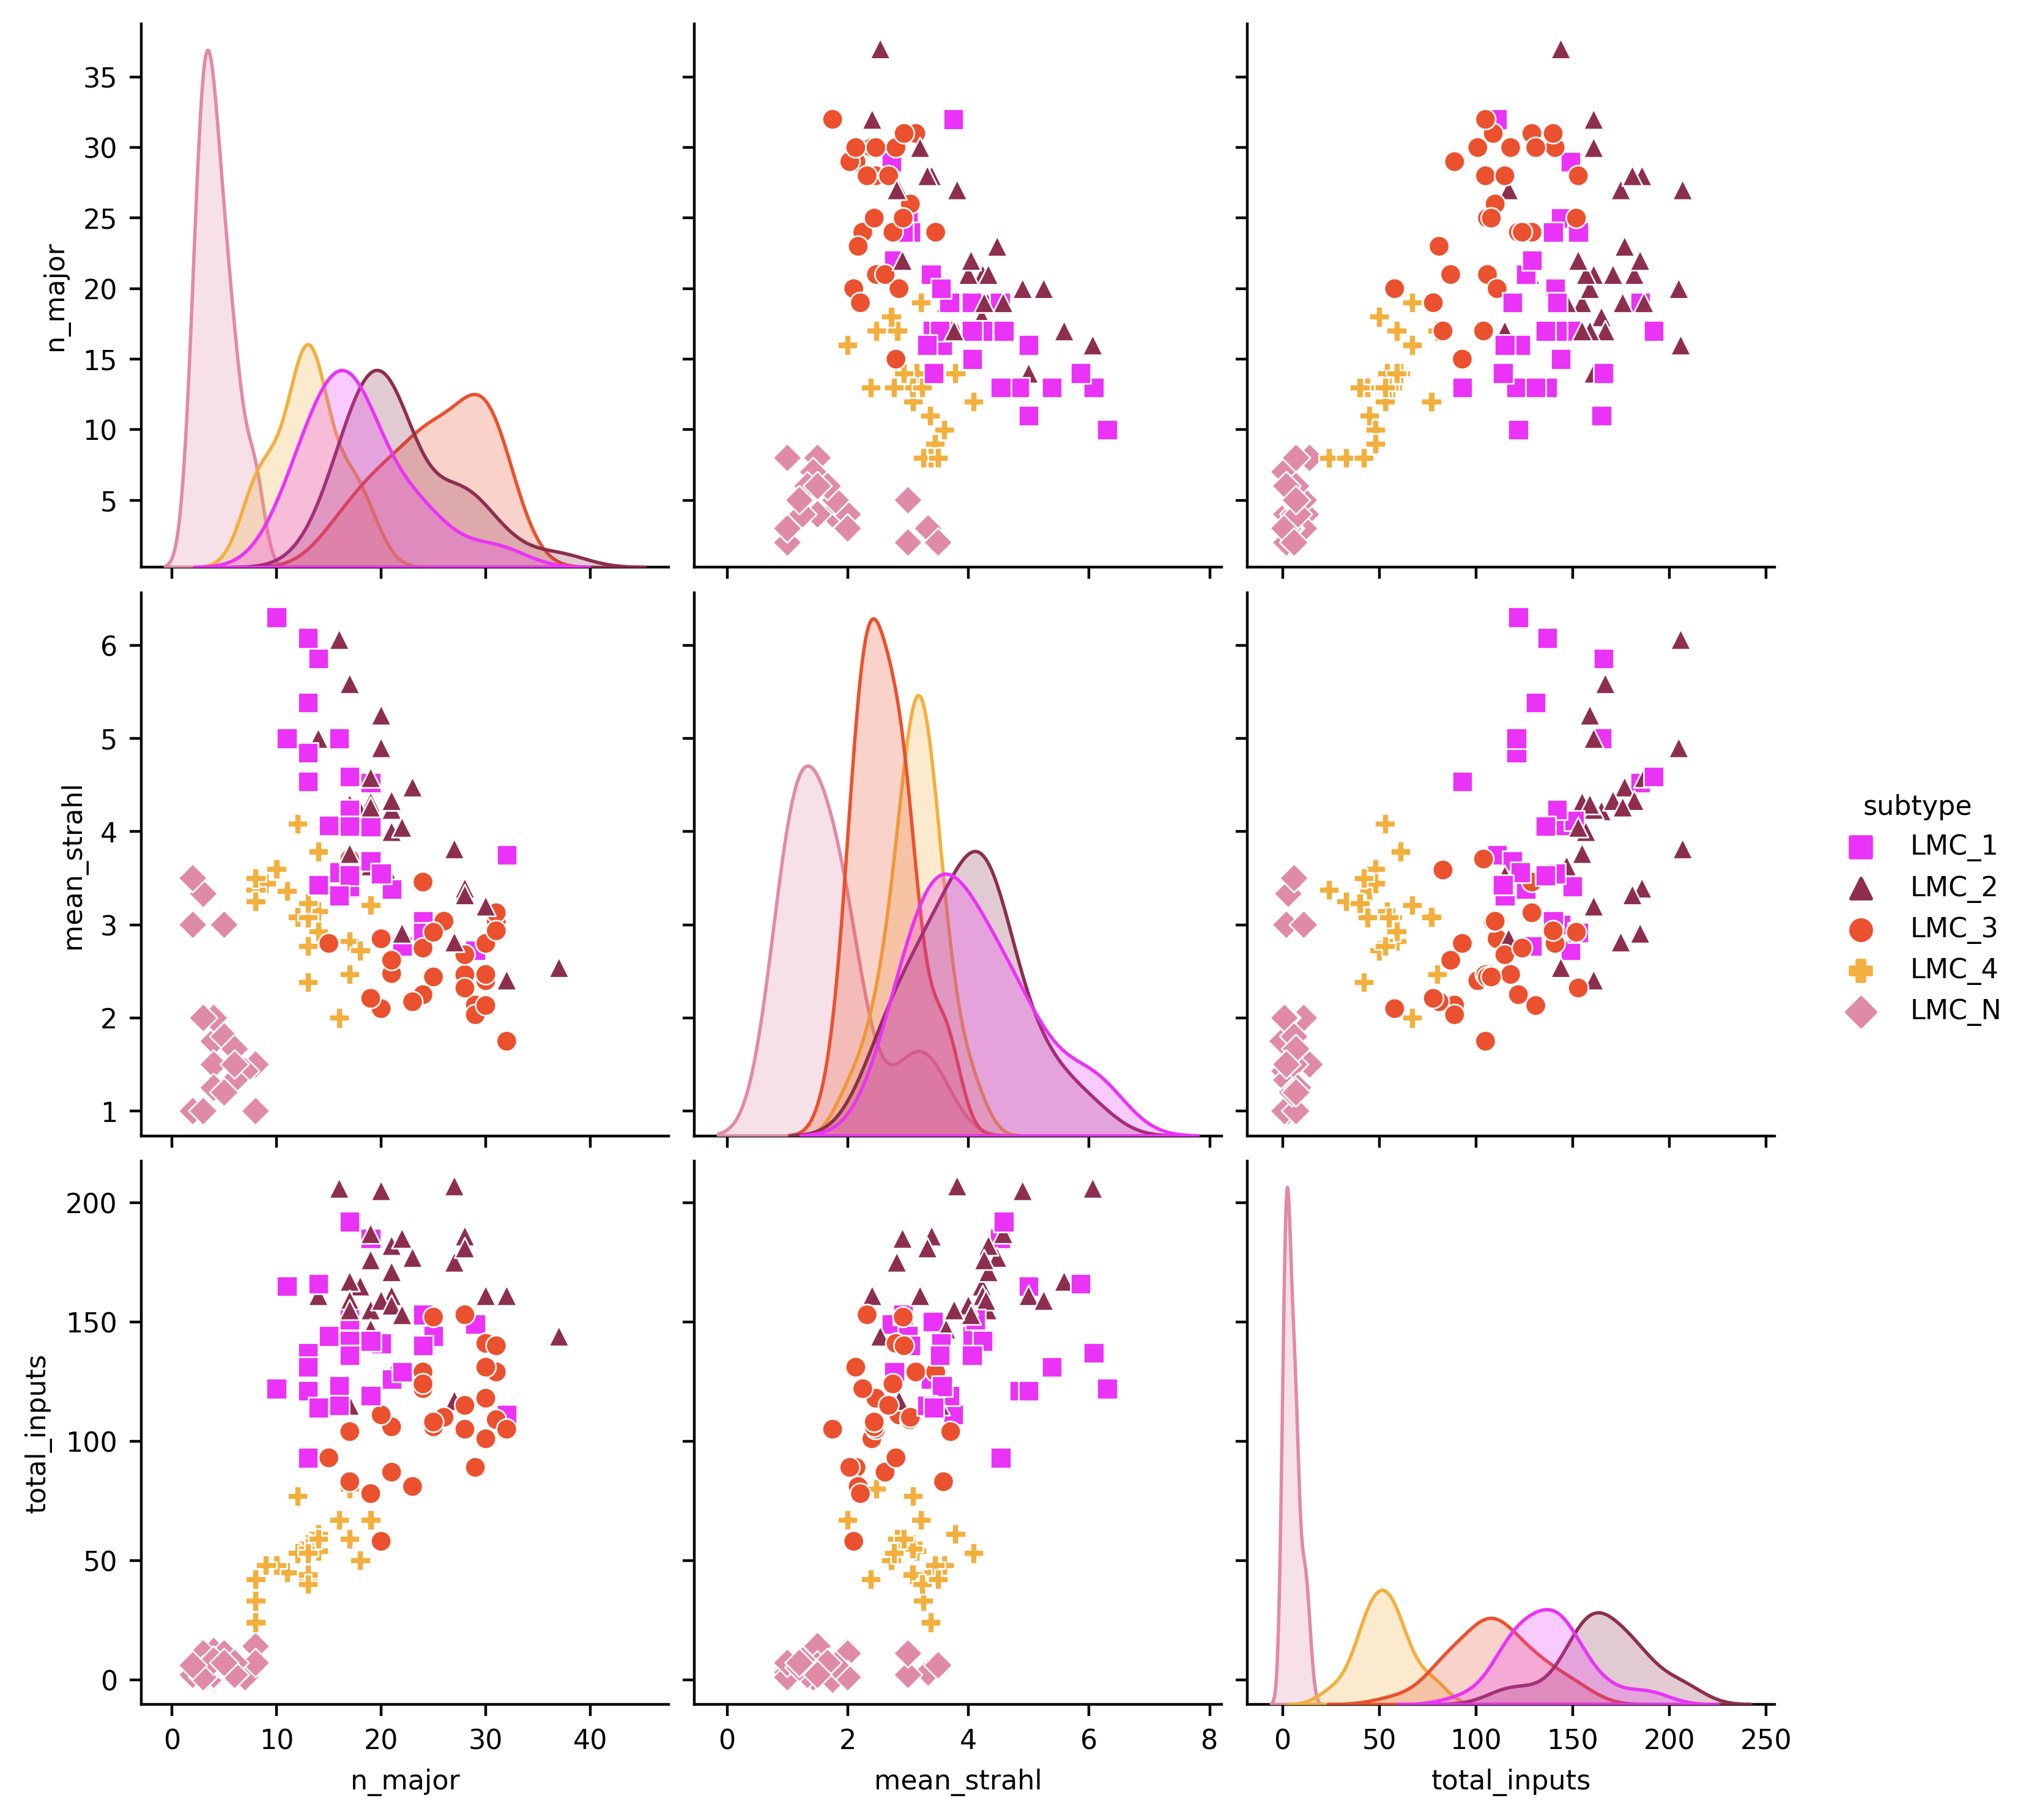

In [26]:
data = major_branches
these_vars=['n_major', 'mean_strahl', 'total_inputs']

m = {'LMC_N': 'D', 'LMC_1': 's', 'LMC_2': '^', 'LMC_3': 'o', 'LMC_4': 'P'}

g = sns.pairplot(data, hue='subtype', markers=m, palette=subtype_cm(), 
             x_vars=these_vars, 
             y_vars=these_vars)
g.savefig('/mnt/home/nchua/Dropbox/lamina_figures/210505_LMC_morp_vs_cx-pair.svg')

In [27]:
for x in x_vars:
    for y in y_vars:
        display(f"Corr between {x} and {y}")
        X = data[x]
        X = sm.add_constant(X)
        Y = data[y]

        model = sm.OLS(Y, X)
        results = model.fit()

        display(results.summary())
        


'Corr between n_major and total_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_inputs   R-squared:                       0.533
Model:                            OLS   Adj. R-squared:                  0.530
Method:                 Least Squares   F-statistic:                     153.0
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           6.50e-24
Time:                        17:35:35   Log-Likelihood:                -700.58
No. Observations:                 136   AIC:                             1405.
Df Residuals:                     134   BIC:                             1411.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.7512      7.963      1.225      0.223      -5.999      25.501
n_major        5.2071      0.421     12.368      0.000       4.374       6.040
==============================================================================
Omnibus:                        9.749   Durbin-Watson:                   1.778
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.212
Skew:                           0.575   Prob(JB):                      0.00999
Kurtosis:                       2.450   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Corr between n_major and R1-6_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            R1-6_inputs   R-squared:                       0.457
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     112.8
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           1.70e-19
Time:                        17:35:35   Log-Likelihood:                -685.97
No. Observations:                 136   AIC:                             1376.
Df Residuals:                     134   BIC:                             1382.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.8762      7.152      0.822      0.413      -8.270      20.022
n_major        4.0165      0.378     10.622      0.000       3.269       4.764
==============================================================================
Omnibus:                        9.760   Durbin-Watson:                   1.715
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.687
Skew:                           0.604   Prob(JB):                      0.00788
Kurtosis:                       2.502   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Corr between n_major and R1436_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           R1436_inputs   R-squared:                       0.336
Model:                            OLS   Adj. R-squared:                  0.331
Method:                 Least Squares   F-statistic:                     67.69
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           1.48e-13
Time:                        17:35:35   Log-Likelihood:                -643.75
No. Observations:                 136   AIC:                             1291.
Df Residuals:                     134   BIC:                             1297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.2592      5.243      1.003      0.318      -5.111      15.630
n_major        2.2807      0.277      8.227      0.000       1.732       2.829
==============================================================================
Omnibus:                        7.241   Durbin-Watson:                   1.587
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                7.371
Skew:                           0.537   Prob(JB):                       0.0251
Kurtosis:                       2.614   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Corr between n_major and R25_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             R25_inputs   R-squared:                       0.587
Model:                            OLS   Adj. R-squared:                  0.584
Method:                 Least Squares   F-statistic:                     190.7
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           1.59e-27
Time:                        17:35:35   Log-Likelihood:                -536.19
No. Observations:                 136   AIC:                             1076.
Df Residuals:                     134   BIC:                             1082.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6170      2.378      0.259      0.796      -4.086       5.320
n_major        1.7358      0.126     13.808      0.000       1.487       1.984
==============================================================================
Omnibus:                        8.775   Durbin-Watson:                   2.071
Prob(Omnibus):                  0.012   Jarque-Bera (JB):                9.384
Skew:                           0.636   Prob(JB):                      0.00917
Kurtosis:                       2.801   Cond. No.                         41.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Corr between mean_strahl and total_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_inputs   R-squared:                       0.456
Model:                            OLS   Adj. R-squared:                  0.452
Method:                 Least Squares   F-statistic:                     112.5
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           1.83e-19
Time:                        17:35:35   Log-Likelihood:                -710.90
No. Observations:                 136   AIC:                             1426.
Df Residuals:                     134   BIC:                             1432.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -13.1256     11.135     -1.179      0.241     -35.148       8.897
mean_strahl    35.4363      3.340     10.609      0.000      28.830      42.043
==============================================================================
Omnibus:                        5.120   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.077   Jarque-Bera (JB):                2.905
Skew:                          -0.121   Prob(JB):                        0.234
Kurtosis:                       2.326   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Corr between mean_strahl and R1-6_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            R1-6_inputs   R-squared:                       0.450
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     109.8
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           3.94e-19
Time:                        17:35:35   Log-Likelihood:                -686.82
No. Observations:                 136   AIC:                             1378.
Df Residuals:                     134   BIC:                             1383.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -17.9610      9.328     -1.926      0.056     -36.410       0.488
mean_strahl    29.3163      2.798     10.477      0.000      23.782      34.851
==============================================================================
Omnibus:                        2.798   Durbin-Watson:                   1.678
Prob(Omnibus):                  0.247   Jarque-Bera (JB):                2.043
Skew:                          -0.123   Prob(JB):                        0.360
Kurtosis:                       2.453   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Corr between mean_strahl and R1436_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           R1436_inputs   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     109.9
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           3.81e-19
Time:                        17:35:35   Log-Likelihood:                -630.83
No. Observations:                 136   AIC:                             1266.
Df Residuals:                     134   BIC:                             1271.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         -16.9798      6.180     -2.748      0.007     -29.203      -4.757
mean_strahl    19.4338      1.854     10.483      0.000      15.767      23.100
==============================================================================
Omnibus:                        3.148   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                2.039
Skew:                          -0.055   Prob(JB):                        0.361
Kurtosis:                       2.410   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

'Corr between mean_strahl and R25_inputs'

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             R25_inputs   R-squared:                       0.352
Model:                            OLS   Adj. R-squared:                  0.347
Method:                 Least Squares   F-statistic:                     72.79
Date:                Wed, 21 Jul 2021   Prob (F-statistic):           2.72e-14
Time:                        17:35:35   Log-Likelihood:                -566.87
No. Observations:                 136   AIC:                             1138.
Df Residuals:                     134   BIC:                             1144.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.9812      3.861     -0.254      0.800      -8.618       6.656
mean_strahl     9.8825      1.158      8.532      0.000       7.592      12.173
==============================================================================
Omnibus:                        3.429   Durbin-Watson:                   1.692
Prob(Omnibus):                  0.180   Jarque-Bera (JB):                2.331
Skew:                           0.131   Prob(JB):                        0.312
Kurtosis:                       2.414   Cond. No.                         10.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""